In [1]:
import os, datetime, time, re, warnings, gc, json, random, yaml, pickle

from contextlib import contextmanager

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from pandas.core.common import SettingWithCopyWarning

from sklearn.cluster import MiniBatchKMeans

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

pd.set_option("display.width", 1000)
pd.set_option("display.max_columns", 256)
pd.set_option("display.max_rows", 256)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Noto Sans CJK JP']

In [2]:
def focus_pref(df, weight=100):
    df["pref_code"] = df["pref_code"] * weight
    
    return df

In [3]:
df = pd.read_pickle("./structure_df_01.pkl")
df.head()

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
0,79 07B198B,（仮称）ＨＴＣ技術センター新築工事,研究施設,神奈川県横浜市都筑区,22214.97,1-6-0,SC造,14,392,1,6,0,9
1,79 08B250B,国立音楽大学新校舎建設工事,大学,東京都立川市,17277.40,0-0-0,RC造,13,392,0,0,0,0
2,79 09A245A,八幡大神社楼門新築計画,社寺教会,東京都三鷹市,30.12,0-1-0,W造,13,392,0,1,0,2
3,75 09A014,デンカ生研鏡田工場５５号棟建設工事,事務所,新潟県五泉市,3400.00,0-3-0,S造,15,392,0,3,0,2
4,93 09A002,ホンダ・タイ工場環境試験室増設工事,生産施設,海外タイ アユタヤ県,500.00,0-0-0,RC造,55,764,0,0,0,1


### 処理済み特徴量の読み込み

In [4]:
train = pd.read_pickle("./structure_train_01.pkl")
train = focus_pref(train)

In [5]:
kmeans = MiniBatchKMeans(n_clusters=10, random_state=42)
kmeans.fit(train)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

### 分類結果を分析用のデータに反映

In [6]:
df["k_class"] = kmeans.predict(train)

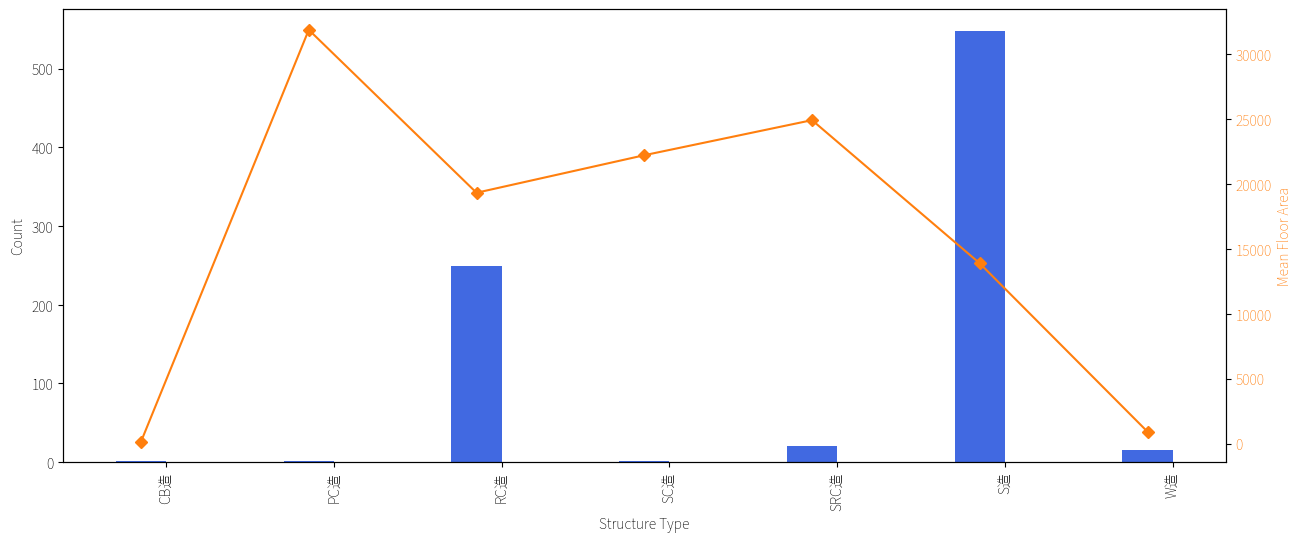

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(15, 6), dpi=100)
tt = df.groupby("structure_type").size().values
ind = np.arange(len(tt))
width = 0.3

b = axes.bar(ind, tt, width, color='royalblue')
axes.set_ylabel("Count");
axes.set_xlabel("Structure Type");
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(np.sort(df["structure_type"].unique()), rotation=90)

axes2 = axes.twinx()
axes2.plot(ind, df.groupby("structure_type")["floor_area"].mean(), 'D-', color='tab:orange', label='Mean Floor Area');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean Floor Area', color='tab:orange');

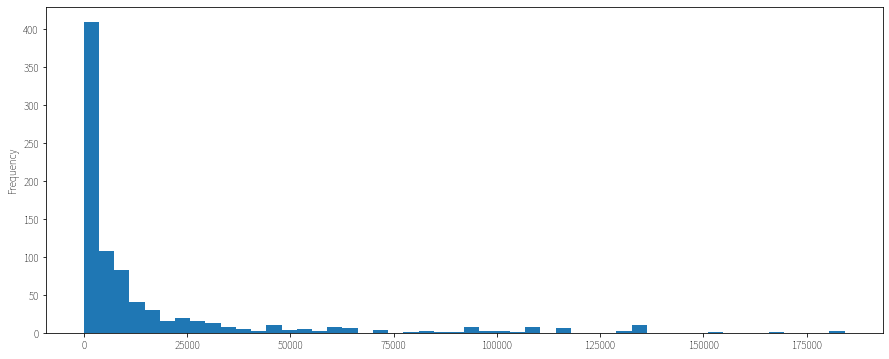

In [8]:
plt.rc('figure', figsize=(15, 6))
df["floor_area"].plot.hist(bins=50)

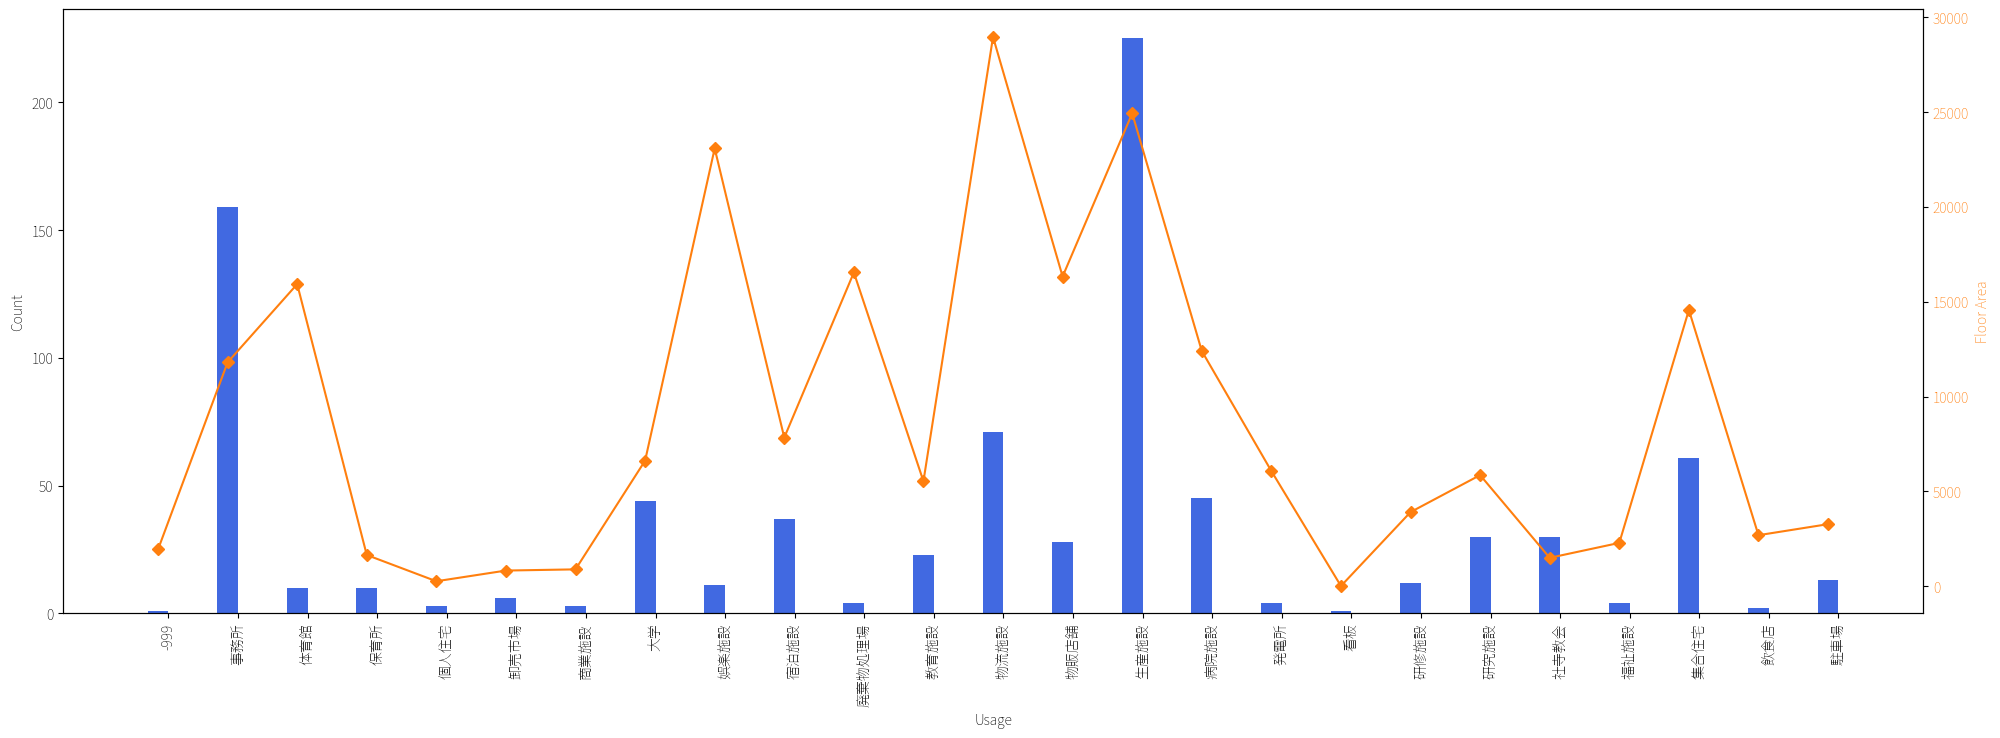

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(24, 8), dpi=100)
df["usage"] = df["usage"].astype(str)
tt = df.groupby("usage").size().values
ind = np.arange(len(tt))
width = 0.3

b = axes.bar(ind, tt, width, color='royalblue')
axes.set_ylabel("Count");
axes.set_xlabel("Usage");
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(np.sort(df["usage"].unique()), rotation=90)

axes2 = axes.twinx()
axes2.plot(ind, df.groupby("usage")["floor_area"].mean(), 'D-', color='tab:orange', label='Mean Floor Area');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Floor Area', color='tab:orange');

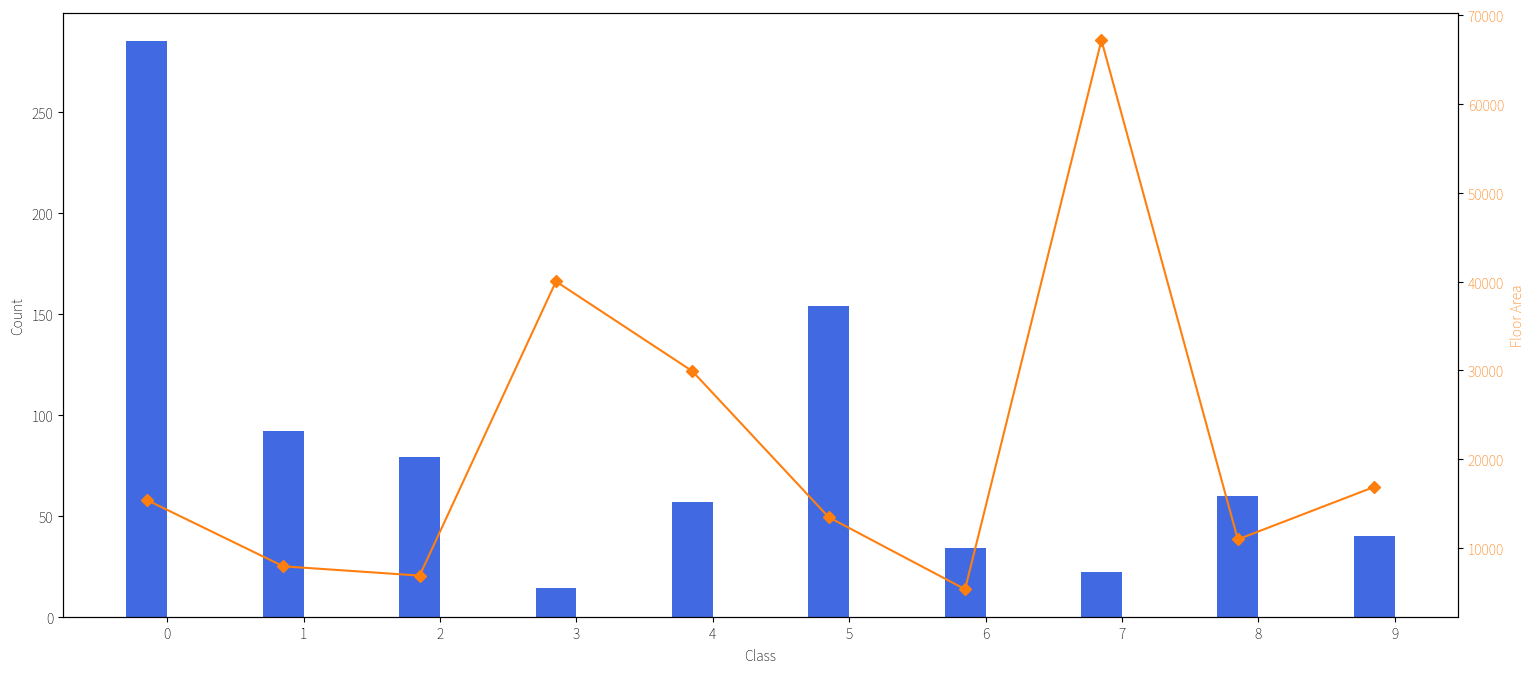

In [10]:
fig, axes = plt.subplots(1, 1, figsize=(18, 8), dpi=100)
tt = df.groupby("k_class").size().values
ind = np.arange(len(tt))
width = 0.3

b = axes.bar(ind, tt, width, color='royalblue')
axes.set_ylabel("Count");
axes.set_xlabel("Class");
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(np.sort(df["k_class"].unique()), rotation=0)

axes2 = axes.twinx()
axes2.plot(ind, df.groupby("k_class")["floor_area"].mean(), 'D-', color='tab:orange', label='Mean Floor Area');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Floor Area', color='tab:orange');

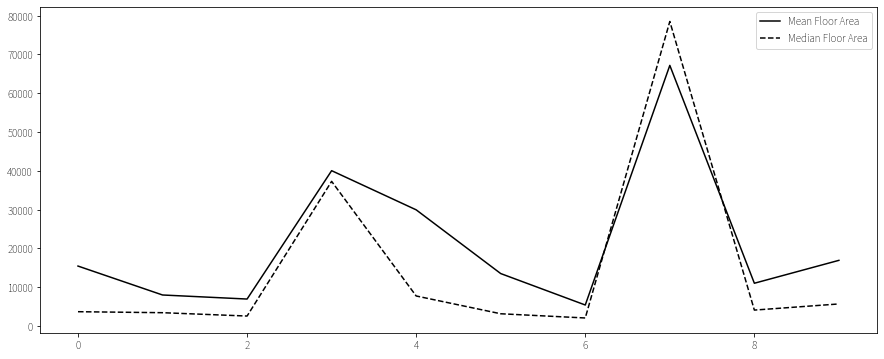

In [11]:
fig = plt.figure(); ax = fig.add_subplot(1, 1, 1)
ax.plot(df.groupby("k_class")["floor_area"].mean(), 'k', label='Mean Floor Area')
ax.plot(df.groupby("k_class")["floor_area"].median(), 'k--', label='Median Floor Area')
ax.legend(loc='best')

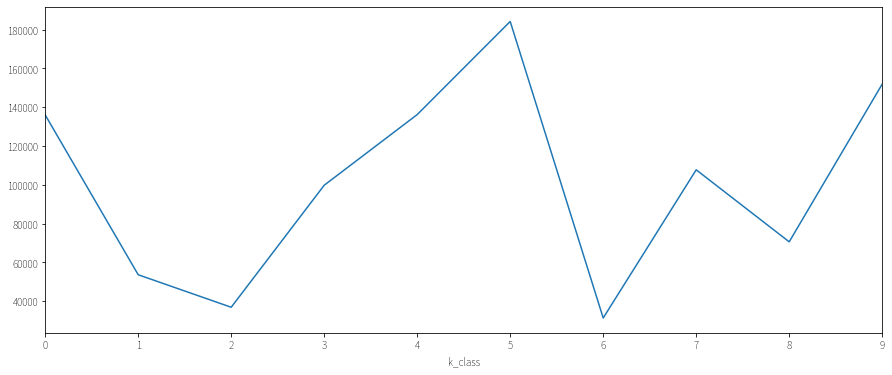

In [12]:
tmp = df.groupby("k_class").agg({"floor_area": ["min", "max"]})
tmp["diff"] = tmp[("floor_area", "max")] - tmp[("floor_area", "min")]
tmp["diff"].plot()

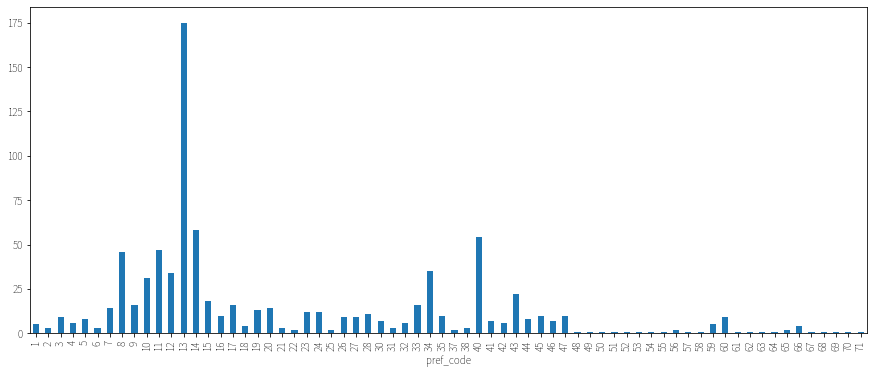

In [13]:
df.groupby("pref_code").size().plot.bar()

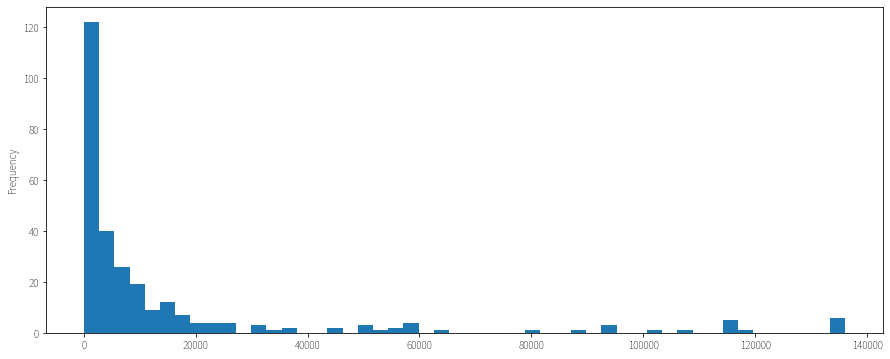

In [14]:
df[df["k_class"]==0]["floor_area"].plot.hist(bins=50)

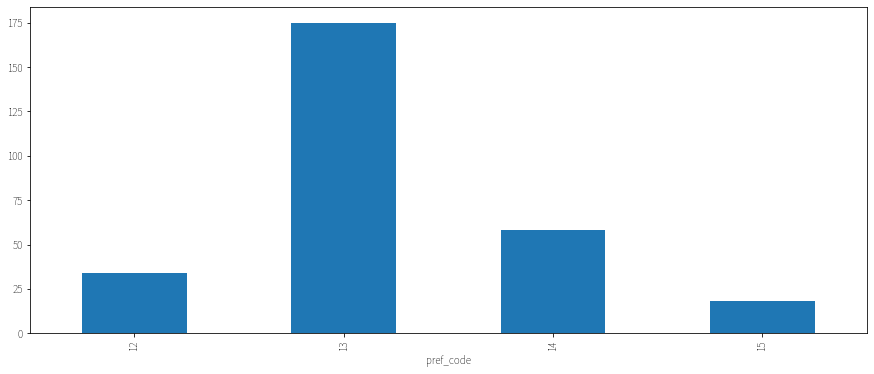

In [15]:
df[df["k_class"]==0].groupby("pref_code").size().plot.bar()

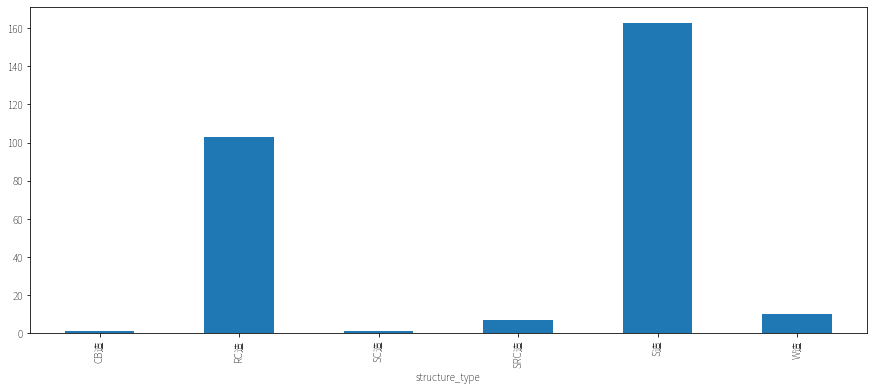

In [16]:
df[df["k_class"]==0].groupby("structure_type").size().plot.bar()

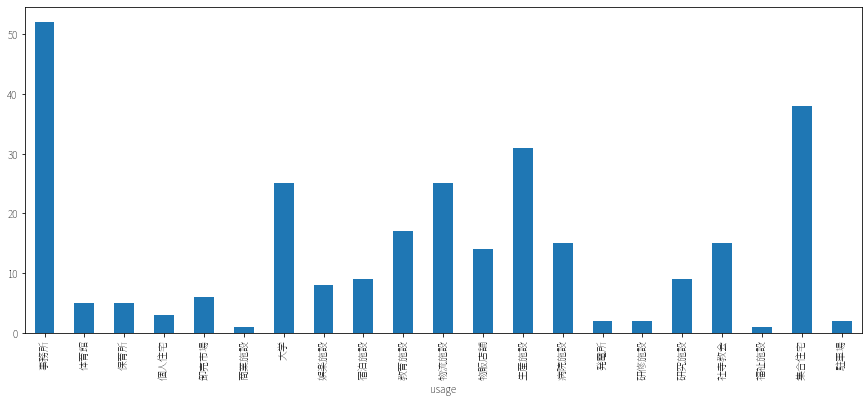

In [17]:
df[df["k_class"]==0].groupby("usage").size().plot.bar()

In [18]:
df[df["k_class"]==0]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
0,79 07B198B,（仮称）ＨＴＣ技術センター新築工事,研究施設,神奈川県横浜市都筑区,22214.97,1-6-0,SC造,14,392,1,6,0,0
1,79 08B250B,国立音楽大学新校舎建設工事,大学,東京都立川市,17277.40,0-0-0,RC造,13,392,0,0,0,0
2,79 09A245A,八幡大神社楼門新築計画,社寺教会,東京都三鷹市,30.12,0-1-0,W造,13,392,0,1,0,0
3,75 09A014,デンカ生研鏡田工場５５号棟建設工事,事務所,新潟県五泉市,3400.00,0-3-0,S造,15,392,0,3,0,0
5,79 04B878C,市川一丁目計画（テナント対応）,集合住宅,千葉県市川市,7218.81,1-13-0,RC造,12,392,1,13,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,79 16B087C,森永高滝アカデミー棟新築工事,娯楽施設,千葉県市原市,186.00,0-1-0,S造,12,392,0,1,0,0
826,79 15A255B,穴八幡宮手水舎・布袋像覆屋新築・追加,社寺教会,東京都新宿区,17.00,0-1-0,W造,13,392,0,1,0,0
831,79 17A315D,昭南荘建替計画・家具,個人住宅,神奈川県足柄下郡箱根町,350.00,1-1-0,W造,14,392,1,1,0,0
833,79 16B062E,日本女子大学目白将来構想2期・準備,大学,東京都文京区,14832.00,1-4-0,SRC造,13,392,1,4,0,0


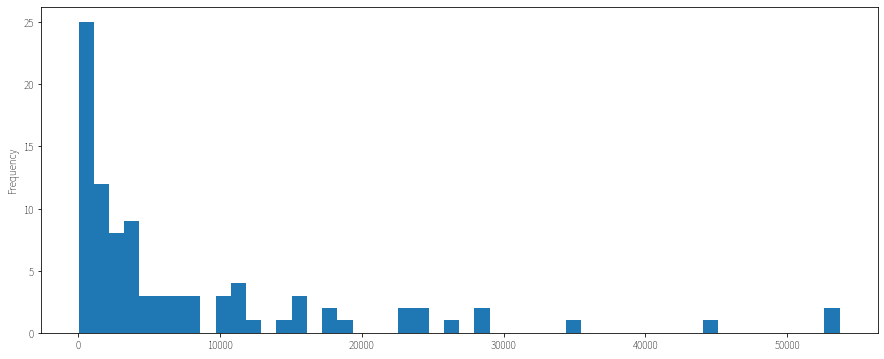

In [19]:
df[df["k_class"]==1]["floor_area"].plot.hist(bins=50)

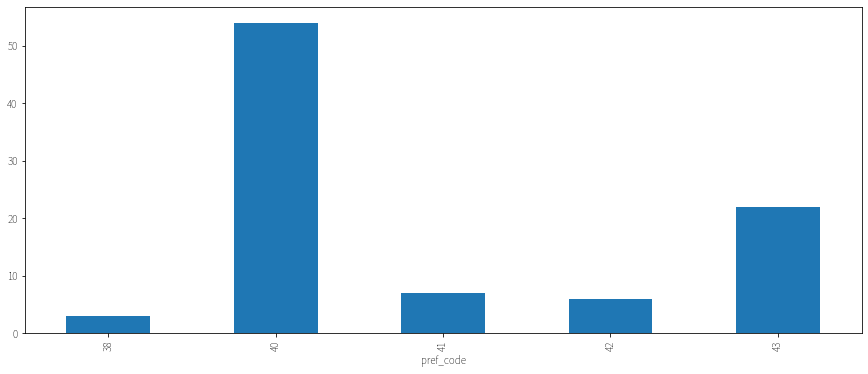

In [20]:
df[df["k_class"]==1].groupby("pref_code").size().plot.bar()

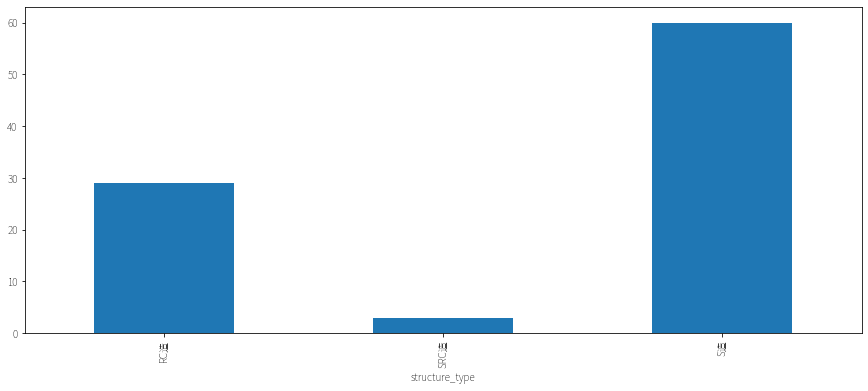

In [21]:
df[df["k_class"]==1].groupby("structure_type").size().plot.bar()

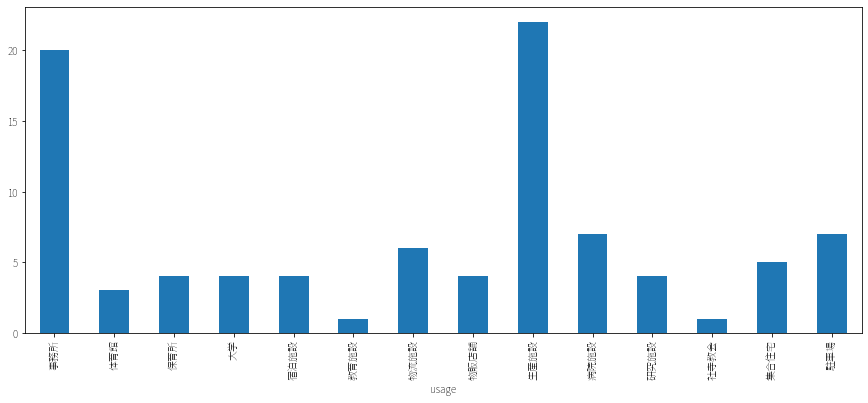

In [22]:
df[df["k_class"]==1].groupby("usage").size().plot.bar()

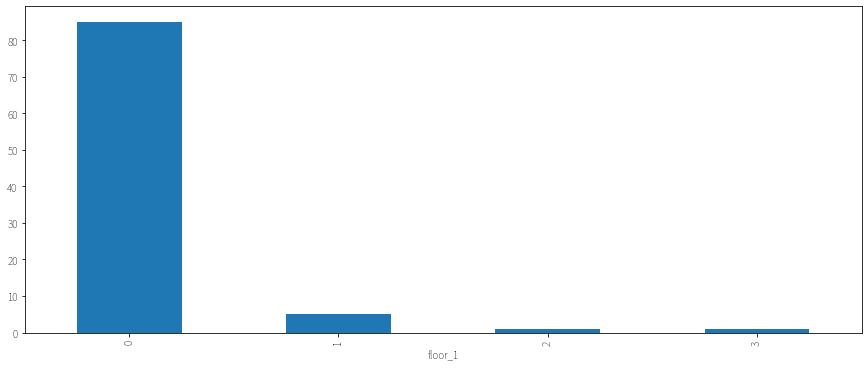

In [23]:
df[df["k_class"]==1].groupby("floor_1").size().plot.bar()

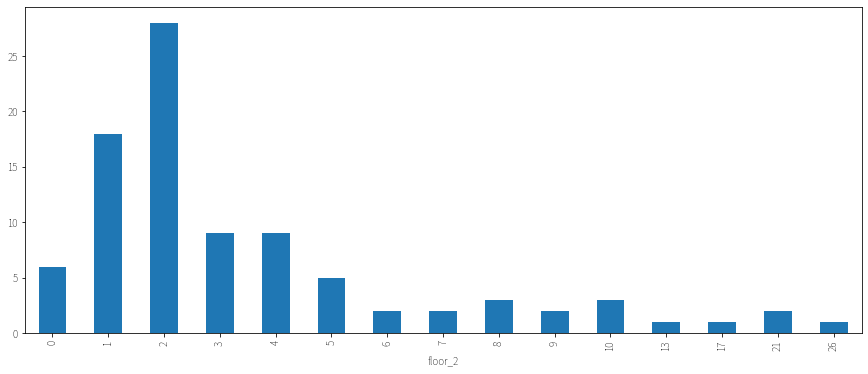

In [24]:
df[df["k_class"]==1].groupby("floor_2").size().plot.bar()

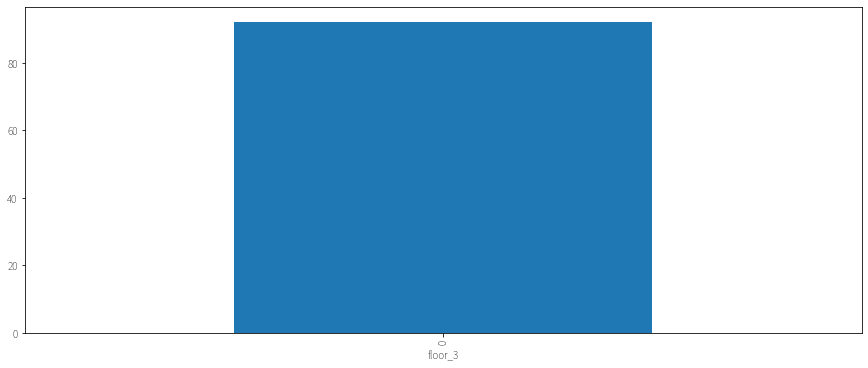

In [25]:
df[df["k_class"]==1].groupby("floor_3").size().plot.bar()

In [26]:
df[df["k_class"]==1]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
8,79 09A556A,※東邦薬品熊本物流センター計画,物流施設,熊本県荒尾市,15278.400,0-2-0,RC造,43,392,0,2,0,1
12,74 09A089,熊本工機本社工場荷捌き場新築工事,生産施設,熊本県玉名郡南関町大字四ﾂ原1280,110.000,0-1-0,S造,43,392,0,1,0,1
25,74 09A011,ゆめマートうきは新築工事,物販店舗,福岡県うきは市,9934.910,0-1-0,S造,40,392,0,1,0,1
33,74S09A004,すがお内科クリニック新築工事,病院施設,福岡県福岡市城南区,223.000,0-2-0,RC造,40,392,0,2,0,1
36,74 09A054,ふたば幼稚園子育て支援施設計画,保育所,佐賀県佐賀市,300.000,0-1-0,RC造,41,392,0,1,0,1
43,74 07B010A,第一生命厳原支部（実施・監理）,事務所,長崎県対馬市厳原町今屋敷６４９,316.000,0-2-0,RC造,42,392,0,2,0,1
44,74 09A017,オーム電機鳥栖配送センター計画,物流施設,佐賀県鳥栖市,8460.000,0-4-0,S造,41,392,0,4,0,1
45,74 09A031,トヨタリック完成ヤード上屋新設工事上,生産施設,福岡県宮若市,4000.000,0-1-0,S造,40,392,0,1,0,1
57,74 09B062,南ケ丘第二幼稚園計画,保育所,福岡県大野城市,1425.000,0-2-0,RC造,40,392,0,2,0,1
59,74 10B033,やましたクリニック計画,病院施設,福岡県福岡市博多区,2589.620,0-5-0,RC造,40,392,0,5,0,1


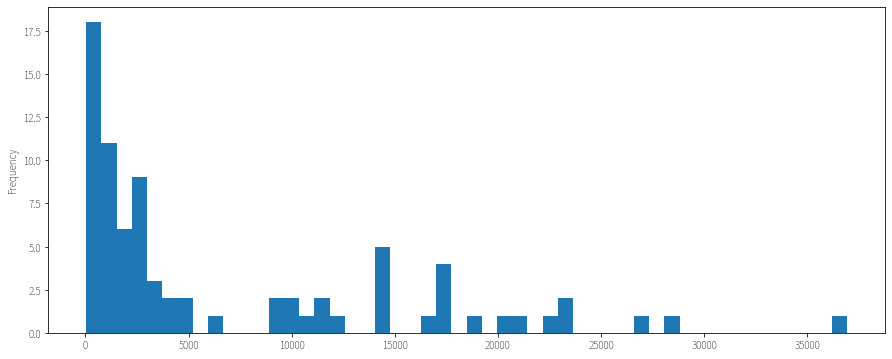

In [27]:
df[df["k_class"]==2]["floor_area"].plot.hist(bins=50)

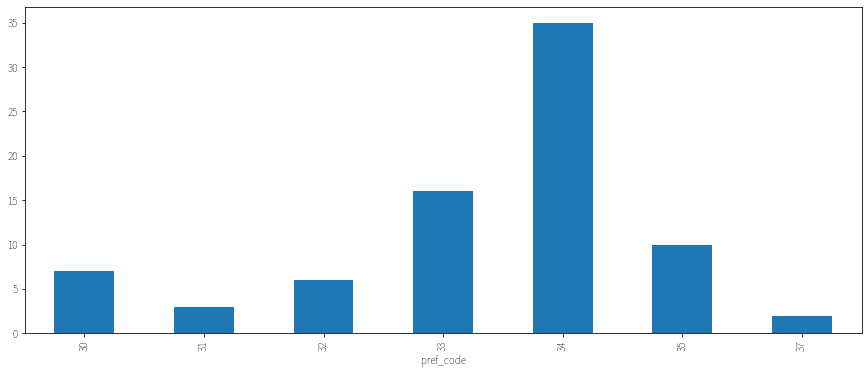

In [28]:
df[df["k_class"]==2].groupby("pref_code").size().plot.bar()

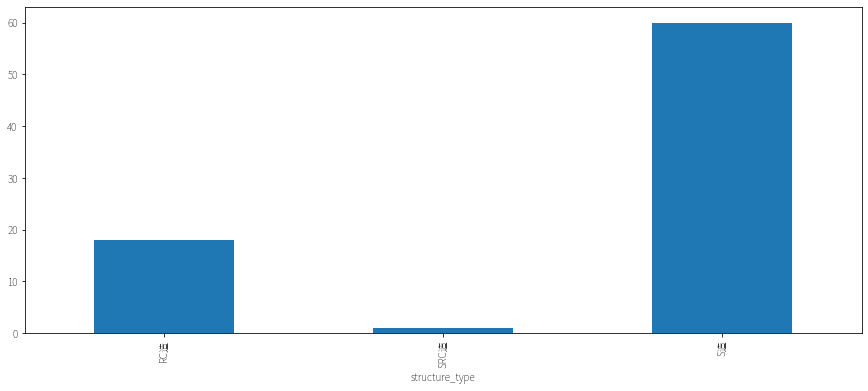

In [29]:
df[df["k_class"]==2].groupby("structure_type").size().plot.bar()

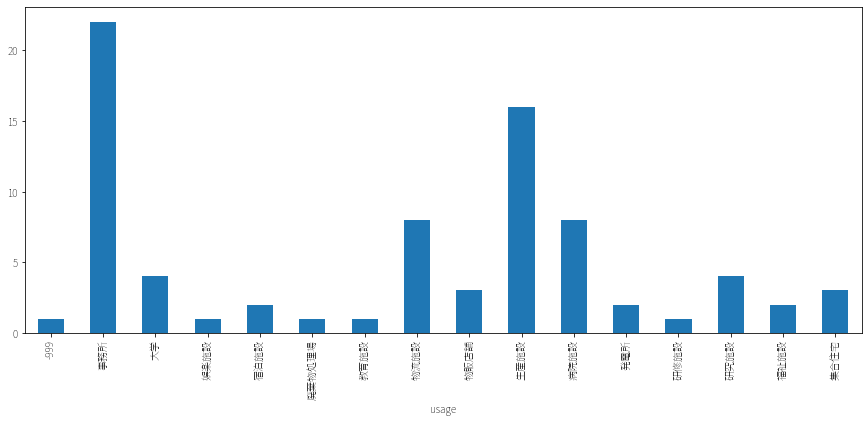

In [30]:
df[df["k_class"]==2].groupby("usage").size().plot.bar()

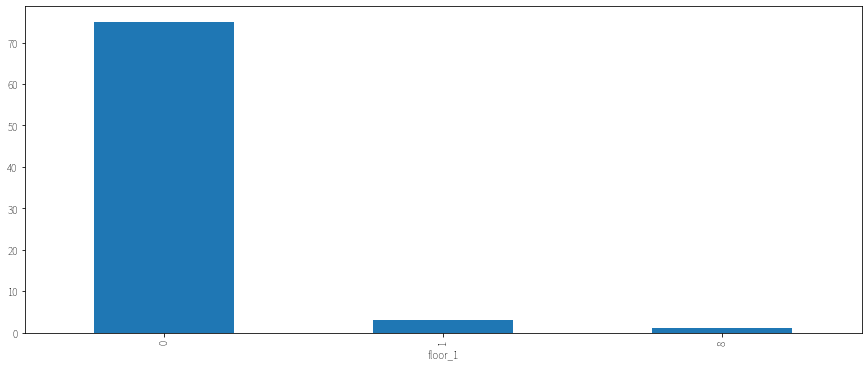

In [31]:
df[df["k_class"]==2].groupby("floor_1").size().plot.bar()

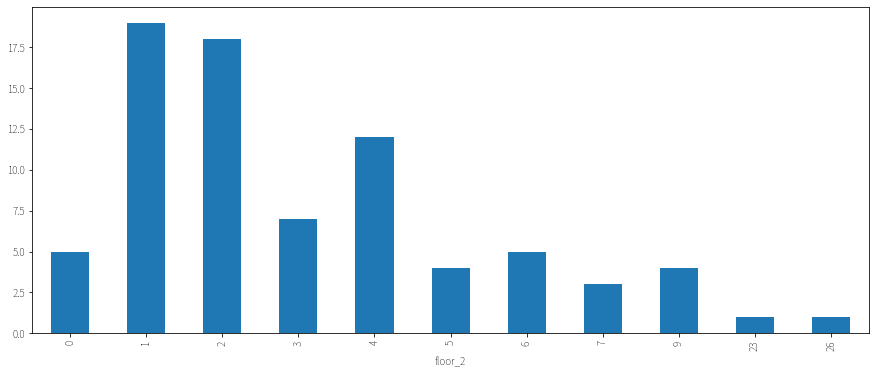

In [32]:
df[df["k_class"]==2].groupby("floor_2").size().plot.bar()

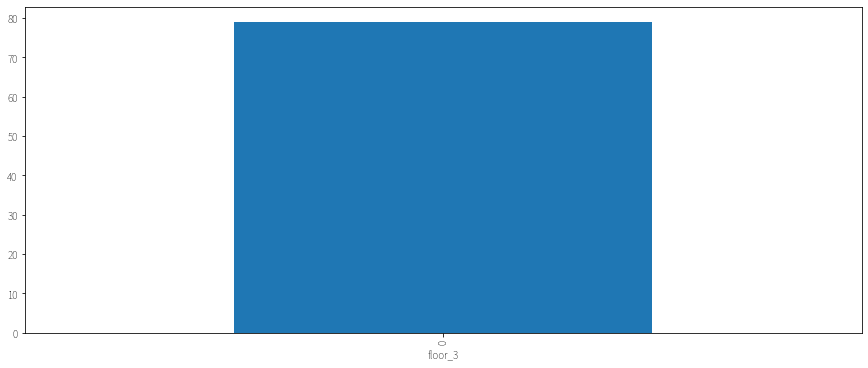

In [33]:
df[df["k_class"]==2].groupby("floor_3").size().plot.bar()

In [34]:
df[df["k_class"]==2]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
6,79 09A540A,花王和歌山新研究施設建設計画,研究施設,和歌山県和歌山市,22234.09,0-7-2,S造,30,392,0,7,0,2
7,79 09A540C,花王和歌山新研究施設建設計画（温室）,研究施設,和歌山県和歌山市,2361.00,0-3-0,S造,30,392,0,3,0,2
15,79 09B033B,シャープ福山第２センタービル計画,事務所,広島県福山市,10000.00,0-5-0,S造,34,392,0,5,0,2
40,72 09A031A,大山町農産物処理加工施設建設（実施）,生産施設,鳥取県西伯郡大山町,491.57,0-1-0,S造,31,392,0,1,0,2
67,72 08B029B,幸陽船渠（株）塗装・ブラスト工場新築工事,生産施設,広島県三原市,11138.40,0-2-0,S造,34,392,0,2,0,2
68,72 09A031B,大山町農産物処理加工施設建設追加工事,生産施設,鳥取県西伯郡大山町,500.00,0-1-0,S造,31,392,0,1,0,2
70,79 09A540F,花王和歌山新研究施設建設計画（外構・植栽,研究施設,和歌山県和歌山市,2361.00,0-3-0,S造,30,392,0,3,0,2
88,72 08B041A,中央内科クリニック整備計画,病院施設,広島県呉市,3971.00,0-4-0,RC造,34,392,0,4,0,2
104,79 09A540D,花王和歌山新研究施設建設計画（変更対応）,研究施設,和歌山県和歌山市,23000.00,0-7-0,S造,30,392,0,7,0,2
106,72 08B029C,幸陽船渠（株）塗装工場新築工事,生産施設,広島県三原市,9688.00,0-2-0,S造,34,392,0,2,0,2


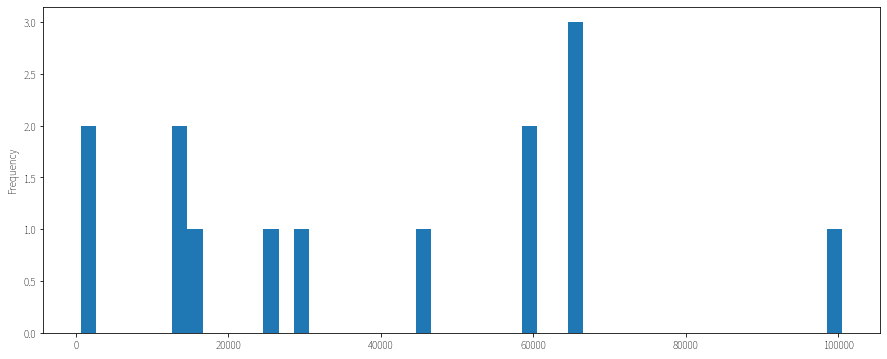

In [35]:
df[df["k_class"]==3]["floor_area"].plot.hist(bins=50)

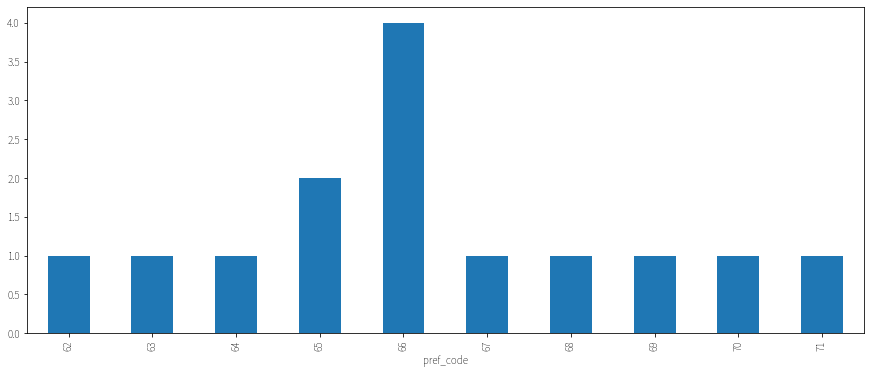

In [36]:
df[df["k_class"]==3].groupby("pref_code").size().plot.bar()

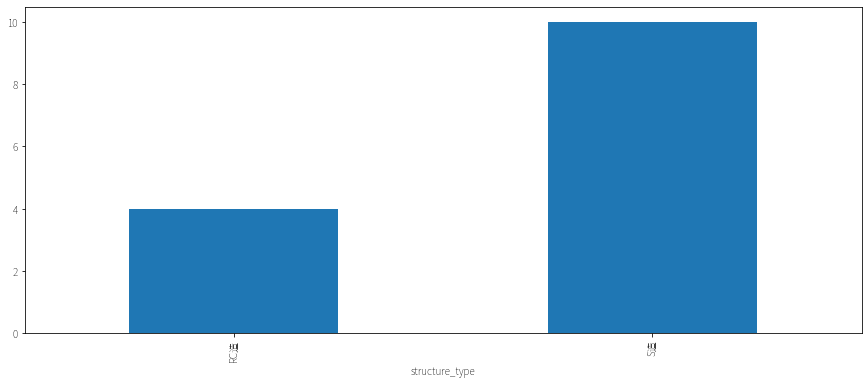

In [37]:
df[df["k_class"]==3].groupby("structure_type").size().plot.bar()

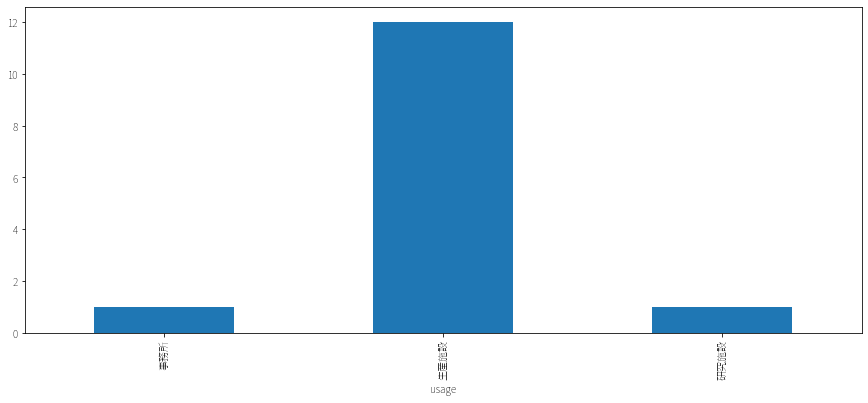

In [38]:
df[df["k_class"]==3].groupby("usage").size().plot.bar()

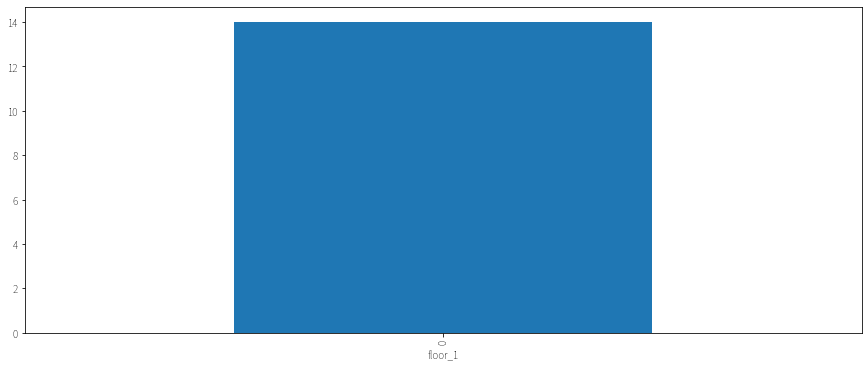

In [39]:
df[df["k_class"]==3].groupby("floor_1").size().plot.bar()

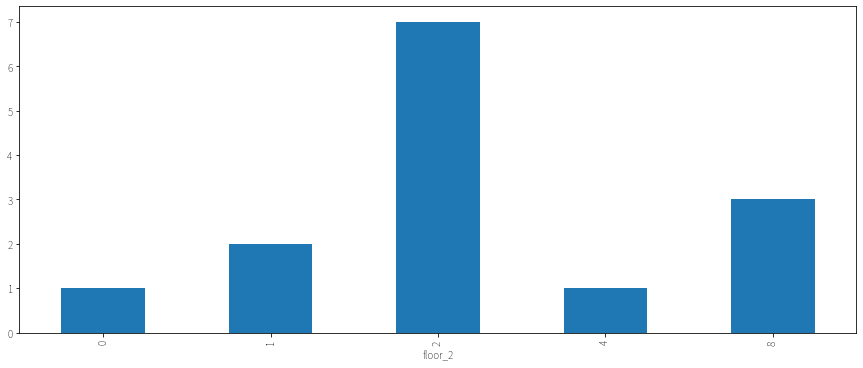

In [40]:
df[df["k_class"]==3].groupby("floor_2").size().plot.bar()

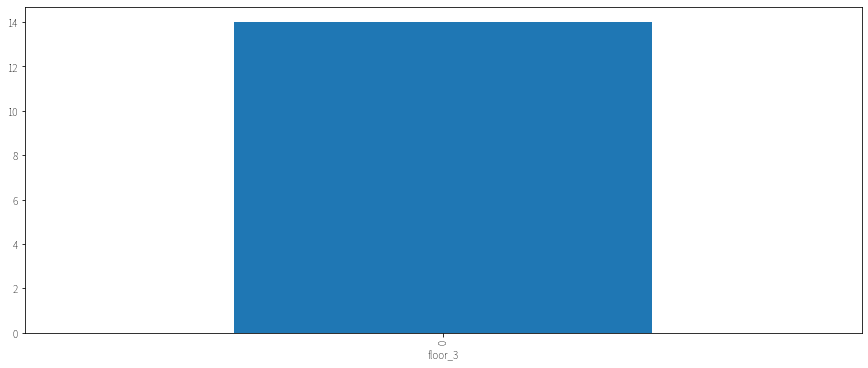

In [41]:
df[df["k_class"]==3].groupby("floor_3").size().plot.bar()

In [42]:
df[df["k_class"]==3]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
21,93 09A037,Ｐ＆ＧベトナムＢｅｎＣａｔ工場新築工事,生産施設,海外ベトナム ビンドゥオン,15900.00,0-2-0,S造,63,704,0,2,0,3
41,93 09A013,常州ピジョン新工場新築工事,研究施設,海外中国 江蘇省,13800.00,0-2-0,RC造,69,156,0,2,0,3
42,93 09A012,アーレスティ広州金型工場建設工事,生産施設,海外中国 広東省,2520.00,0-1-0,RC造,68,156,0,1,0,3
90,93 09B019,みずほＣＢ香港内装工事,事務所,海外香港（中国） 九龍,665.00,0-0-0,S造,71,344,0,0,0,3
105,93 09B052,ベトナム・デンヨーＴＬＩＰ計画,生産施設,海外ベトナム ﾌﾝｲｴﾝ,12700.00,0-1-0,S造,64,704,0,1,0,3
223,79 11A027B,合肥ニプロ新工場建設工事,生産施設,海外中国 安微省,100463.00,0-2-1,RC造,67,156,0,2,0,3
301,79 12A676B,富士ゼロックス海外新生産拠点建設工事,生産施設,海外ベトナム・ハイフォン市,59598.68,0-2-0,S造,65,704,0,2,0,3
305,79 12A676C,富士ゼロックス海外新生産拠点建設工事,生産施設,海外ベトナム・ハイフォン市,59598.67,0-2-0,S造,65,704,0,2,0,3
397,79 11B826A,※安川電機（常州）ロボット工場,生産施設,海外中国江蘇省常洲市,29489.00,0-2-1,RC造,70,156,0,2,0,3
520,79 14A225A,日本電気硝子アモイ工場新築工事－工場南棟,生産施設,海外中国,64938.00,0-8-0,S造,66,156,0,8,0,3


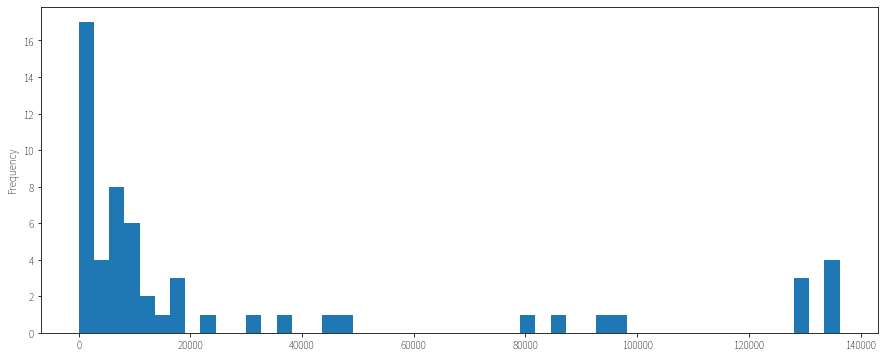

In [43]:
df[df["k_class"]==4]["floor_area"].plot.hist(bins=50)

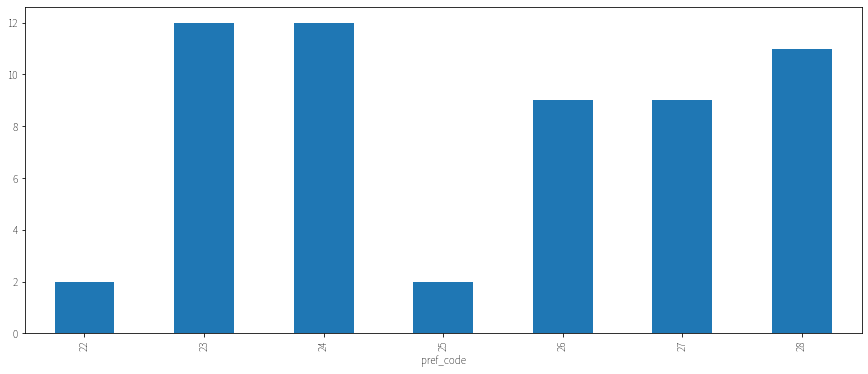

In [44]:
df[df["k_class"]==4].groupby("pref_code").size().plot.bar()

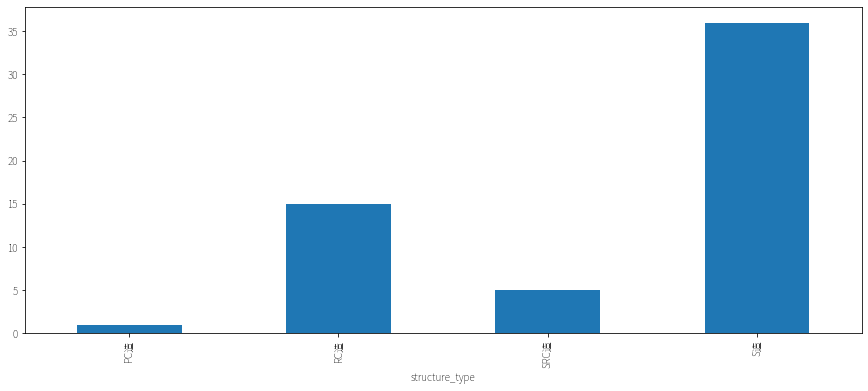

In [45]:
df[df["k_class"]==4].groupby("structure_type").size().plot.bar()

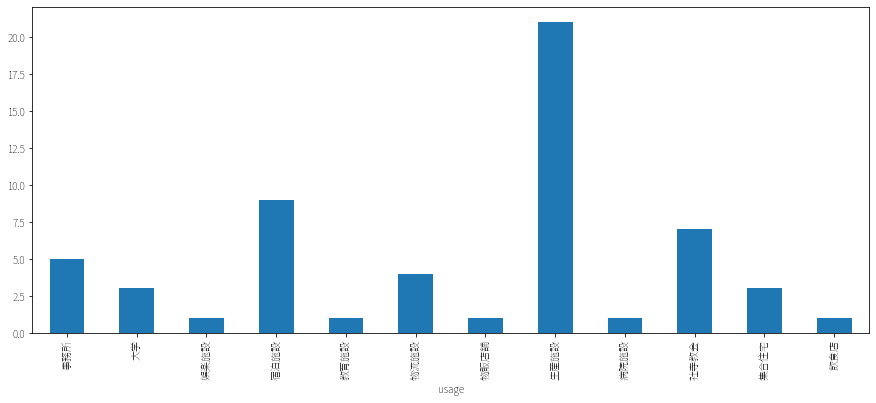

In [46]:
df[df["k_class"]==4].groupby("usage").size().plot.bar()

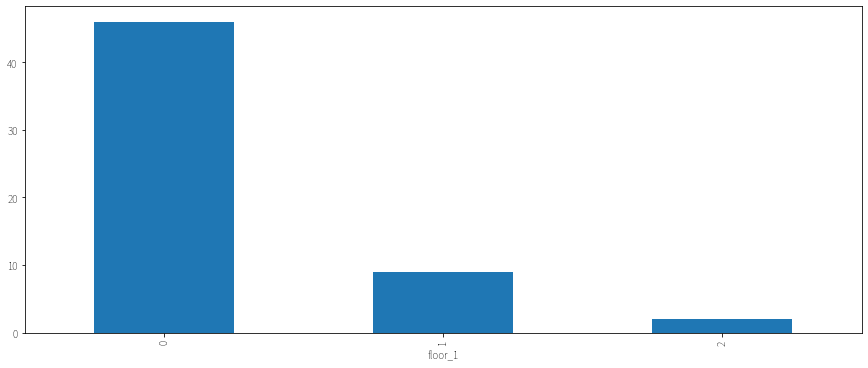

In [47]:
df[df["k_class"]==4].groupby("floor_1").size().plot.bar()

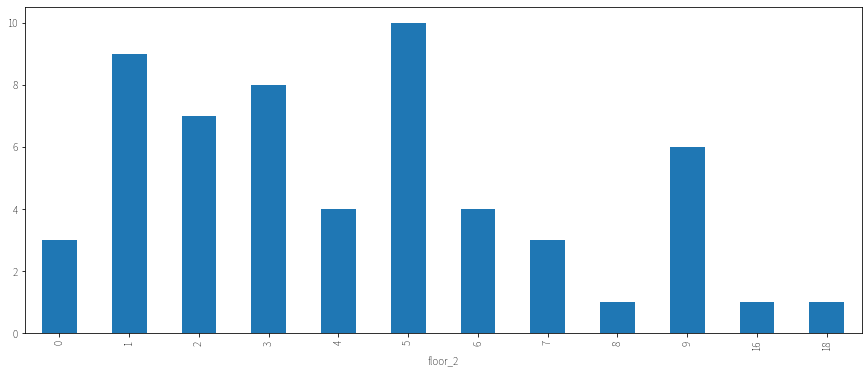

In [48]:
df[df["k_class"]==4].groupby("floor_2").size().plot.bar()

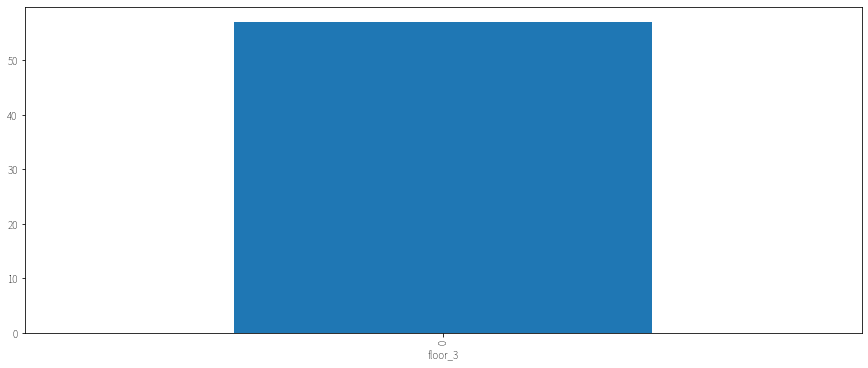

In [49]:
df[df["k_class"]==4].groupby("floor_3").size().plot.bar()

In [50]:
df[df["k_class"]==4]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
16,79 09A255B,伊豆ベロドローム建設計画,娯楽施設,静岡県伊豆市,12905.00,1-3-0,RC造,22,392,1,3,0,4
27,70 09A014,百五銀行豊田支店計画,事務所,愛知県豊田市,744.84,0-2-0,RC造,23,392,0,2,0,4
63,79 08A396B,宗教法人大本教大道場講堂・新大本会館計画,社寺教会,京都府亀岡市,6012.34,0-4-0,RC造,26,392,0,4,0,4
71,71 09B071,神鋼高砂テント倉庫新設計画,物流施設,兵庫県高砂市,691.00,0-1-0,S造,28,392,0,1,0,4
76,79 09A115B,大本大道場講堂新築工事,社寺教会,京都府亀岡市,559.04,0-1-0,S造,26,392,0,1,0,4
77,79 08A090D,東芝四日市メモリ第５製造棟（棟間搬送）,生産施設,三重県四日市市,96000.00,0-5-0,S造,24,392,0,5,0,4
92,75 10A017,三徳磁石原料製造電気室建設工事,生産施設,兵庫県神戸市東灘区深江北町4丁目14番34号,220.00,0-1-0,S造,28,392,0,1,0,4
102,79 08A396C,宗教法人大本教大道場講堂・新大本会館計画,社寺教会,京都府亀岡市,40.00,0-0-0,S造,26,392,0,0,0,4
126,79 10B355A,本門佛立宗宗務本庁舎建替計画,社寺教会,京都府京都市上京区,3391.50,1-4-0,RC造,26,392,1,4,0,4
174,79 10A610A,幸福の科学学園関西中学校・高等学校（仮称,教育施設,滋賀県大津市,23530.30,1-4-0,RC造,25,392,1,4,0,4


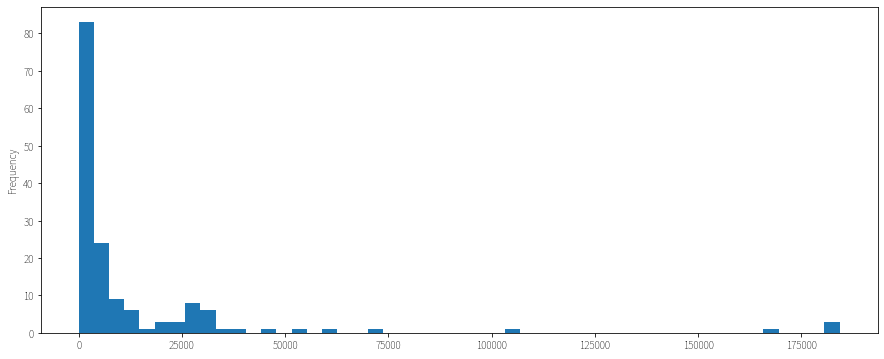

In [51]:
df[df["k_class"]==5]["floor_area"].plot.hist(bins=50)

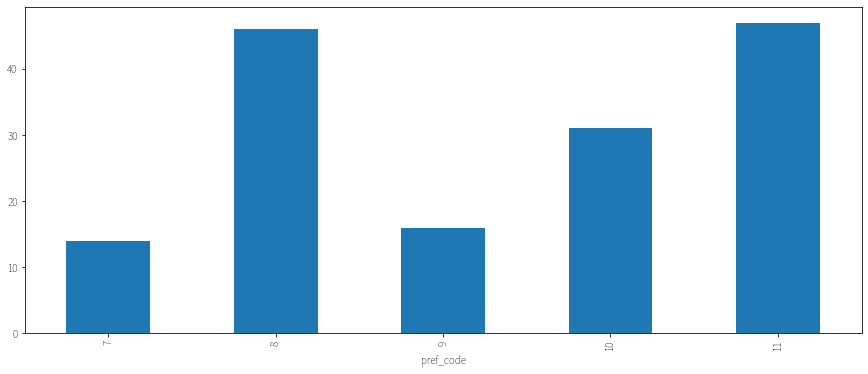

In [52]:
df[df["k_class"]==5].groupby("pref_code").size().plot.bar()

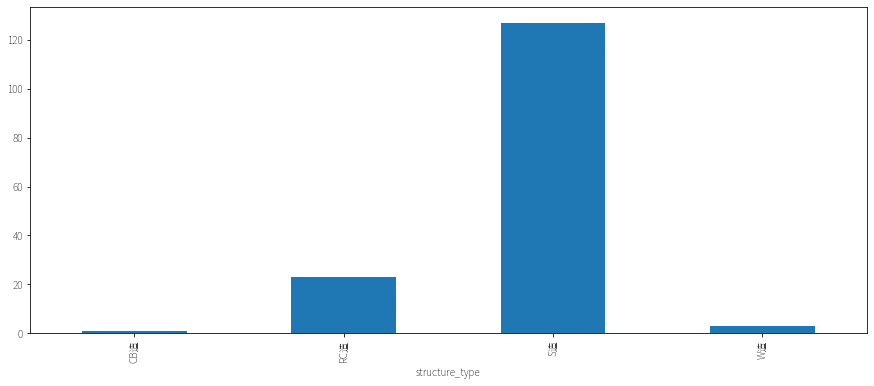

In [53]:
df[df["k_class"]==5].groupby("structure_type").size().plot.bar()

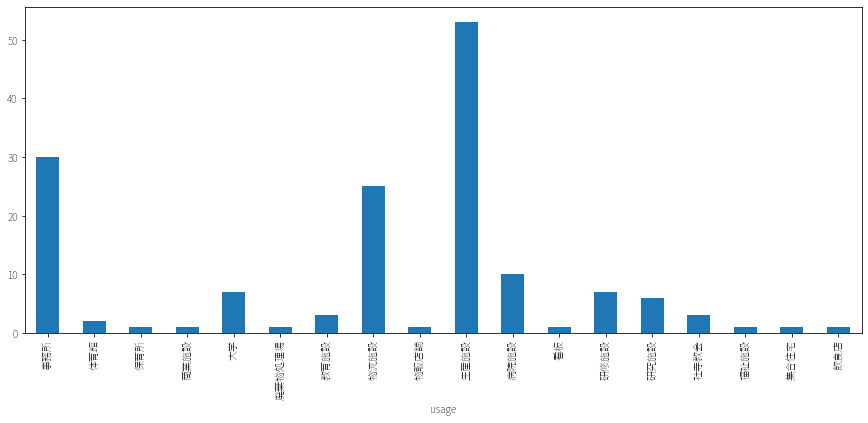

In [54]:
df[df["k_class"]==5].groupby("usage").size().plot.bar()

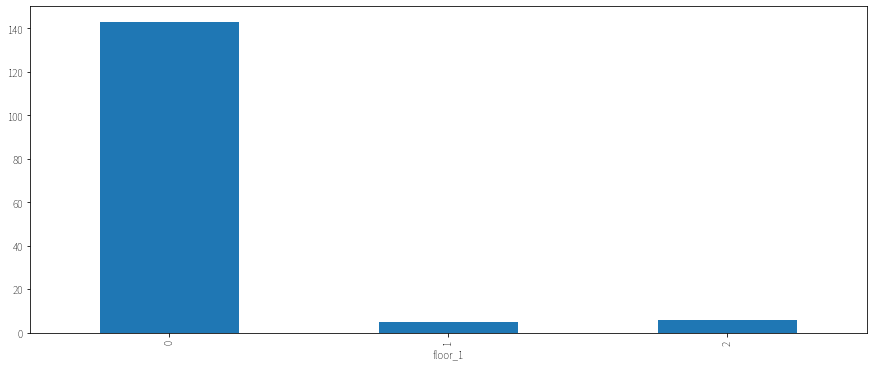

In [55]:
df[df["k_class"]==5].groupby("floor_1").size().plot.bar()

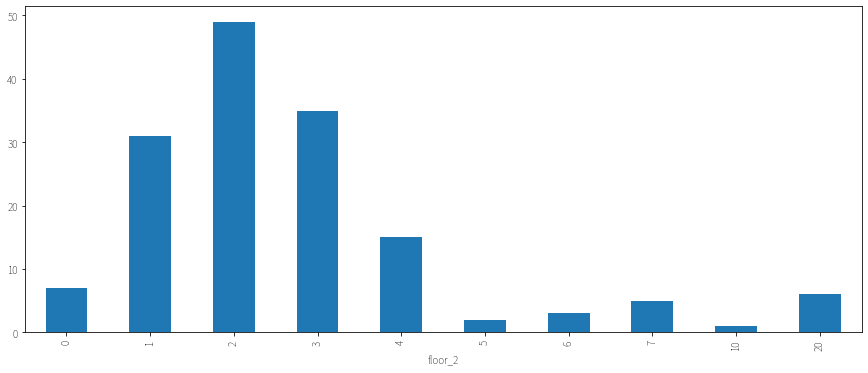

In [56]:
df[df["k_class"]==5].groupby("floor_2").size().plot.bar()

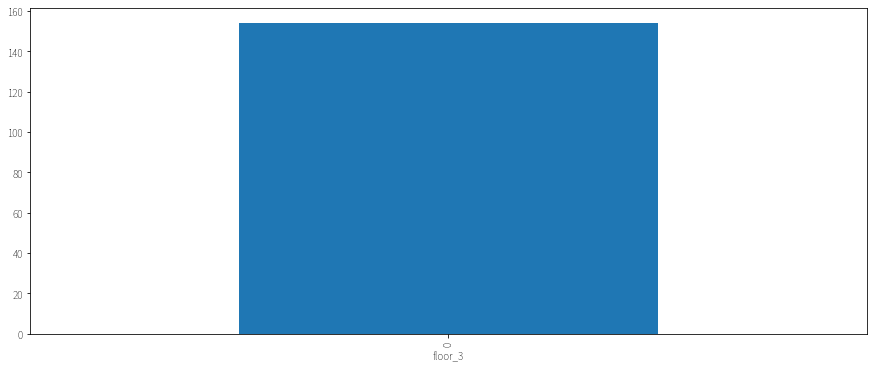

In [57]:
df[df["k_class"]==5].groupby("floor_3").size().plot.bar()

In [58]:
df[df["k_class"]==5]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
28,79 09A293A,東邦薬品埼玉物流センター計画,物流施設,埼玉県南埼玉郡菖蒲町,26000.00,0-3-0,S造,11,392,0,3,0,5
29,79 07B471B,プロロジスパーク埼玉川島Ⅱ期,物流施設,埼玉県比企郡川島町,166659.70,0-5-1,RC造,11,392,0,5,0,5
34,64 09A021,宇野株式会社関東物流センター新築工事,物流施設,栃木県栃木市,4146.56,0-2-0,S造,9,392,0,2,0,5
51,79 09B550A,武蔵一宮氷川神社祈祷殿・神札所新築工事,社寺教会,埼玉県さいたま市大宮区,690.12,0-1-0,W造,11,392,0,1,0,5
53,79 10A432B,ＡＤＥＫＡ浦和新研究棟建設工事,研究施設,埼玉県さいたま市南区,7017.04,0-7-0,RC造,11,392,0,7,0,5
64,64 10A055,（仮称）ビッグ・ビー宇都宮駅東口第２ビル,事務所,栃木県宇都宮市,4000.00,0-10-0,RC造,9,392,0,10,0,5
73,79 10B200A,ホンダ寄居工場建設１期建築工事Ｓ工区,生産施設,埼玉県大里郡寄居町,184227.00,0-4-0,S造,11,392,0,4,0,5
79,64 10A074B,松屋フーズ川島物流センター計画実施設計,生産施設,埼玉県比企郡川島町かわじま１丁目,13186.00,0-3-0,S造,11,392,0,3,0,5
82,76 09B044,郡山税理士会館建替計画,事務所,福島県郡山市,254.45,0-3-0,RC造,7,392,0,3,0,5
96,64 10B009,日本ケミコン高萩Ｋ棟ボイラー用煙突工事,生産施設,茨城県高萩市,6643.69,0-3-0,S造,8,392,0,3,0,5


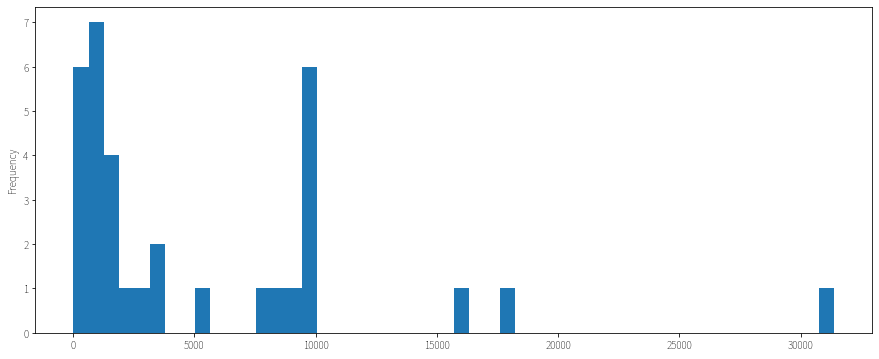

In [59]:
df[df["k_class"]==6]["floor_area"].plot.hist(bins=50)

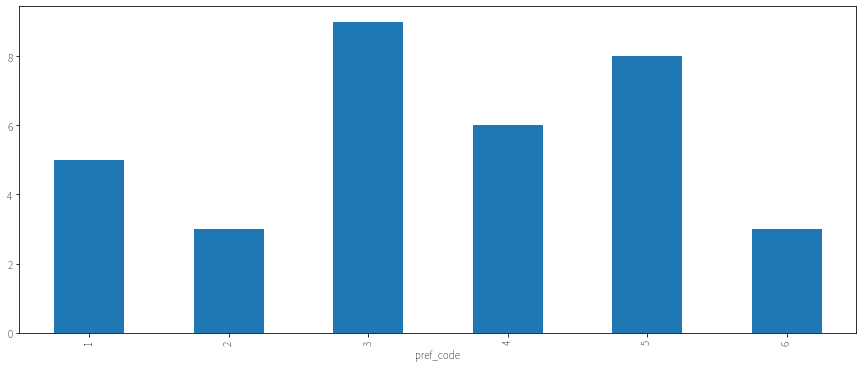

In [60]:
df[df["k_class"]==6].groupby("pref_code").size().plot.bar()

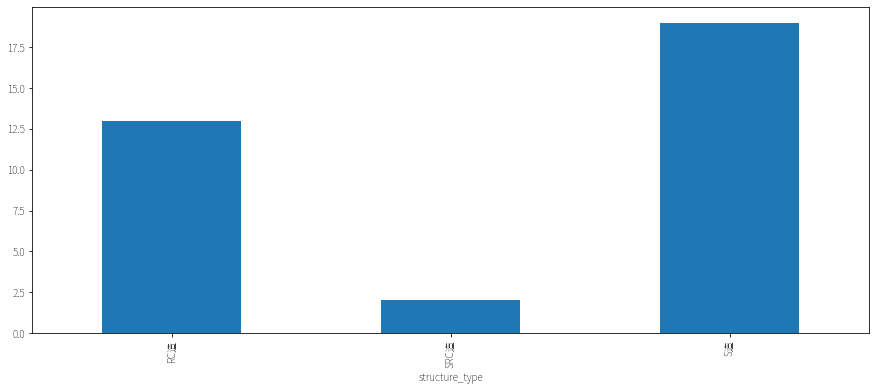

In [61]:
df[df["k_class"]==6].groupby("structure_type").size().plot.bar()

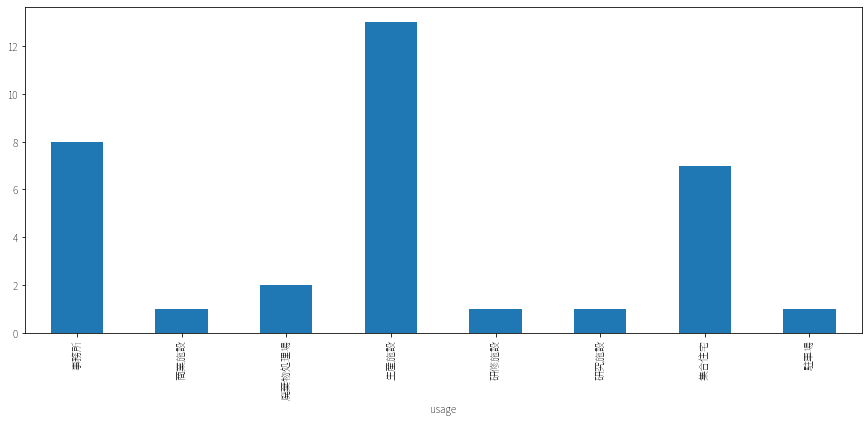

In [62]:
df[df["k_class"]==6].groupby("usage").size().plot.bar()

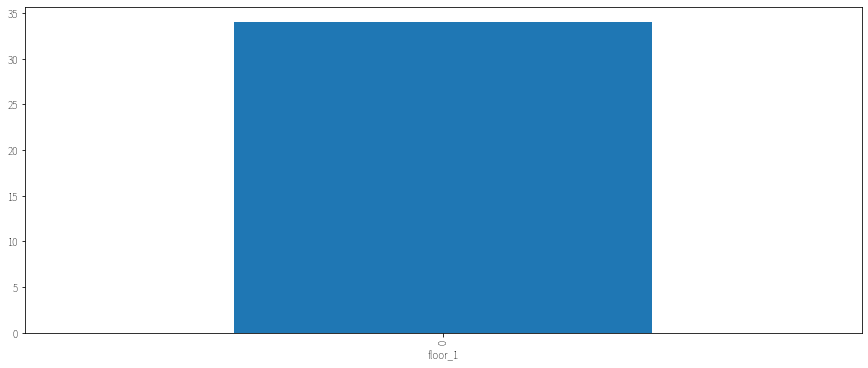

In [63]:
df[df["k_class"]==6].groupby("floor_1").size().plot.bar()

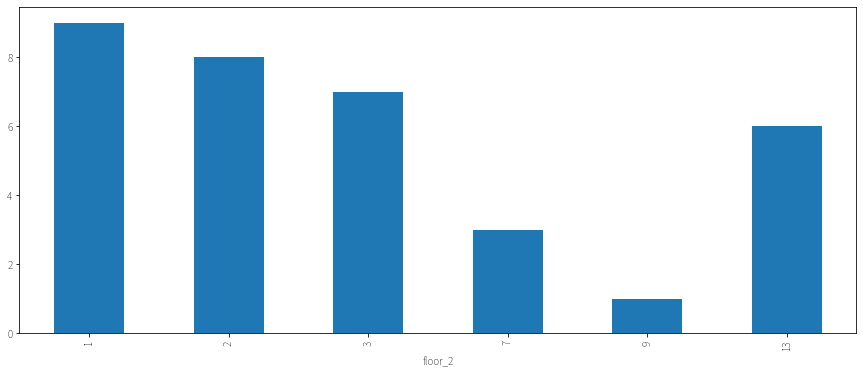

In [64]:
df[df["k_class"]==6].groupby("floor_2").size().plot.bar()

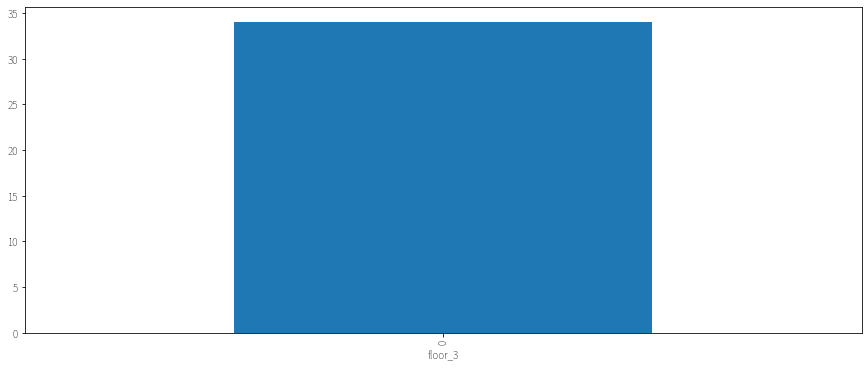

In [65]:
df[df["k_class"]==6].groupby("floor_3").size().plot.bar()

In [66]:
df[df["k_class"]==6]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
69,79 10B335A,キヤノンプレシジョン北和徳第二喫煙所設置,事務所,青森県弘前市,20.00,0-1-0,S造,2,392,0,1,0,6
95,76 10A021,当社盛岡営業所新築（ＭＳプロジェクト）,事務所,岩手県盛岡市,400.00,0-2-0,S造,3,392,0,2,0,6
116,76 10A024,リンナイ東北支社新社屋建設計画,事務所,宮城県仙台市若林区,1679.00,0-2-0,S造,4,392,0,2,0,6
156,76 09A071,ソマテック仙台工場新築工事,研究施設,宮城県黒川郡大和町,8000.00,0-2-0,S造,4,392,0,2,0,6
181,76 11A013,太平洋セメント大船渡工場（事務棟、更衣,生産施設,岩手県大船渡市,1200.00,0-3-0,RC造,3,392,0,3,0,6
227,76 09B057,タカラスタンダード盛岡営業所移転新築,商業施設,岩手県紫波郡矢巾町,664.62,0-1-0,S造,3,392,0,1,0,6
246,76 10A018A,中通一丁目再開発住宅棟パンフレット支援,集合住宅,秋田県秋田市,9936.00,0-13-0,RC造,5,392,0,13,0,6
247,76 11A014,関東自動車工業岩手工場クロスドック新築,生産施設,岩手県胆沢郡金ケ崎町,8550.00,0-1-0,S造,3,392,0,1,0,6
287,76 08B021A,山王セントラルビルテナントＦ対応工事,事務所,秋田県秋田市,3240.00,0-7-0,SRC造,5,392,0,7,0,6
288,76 08B021B,山王セントラルビルテナントＳ対応工事,事務所,秋田県秋田市,3240.00,0-7-0,SRC造,5,392,0,7,0,6


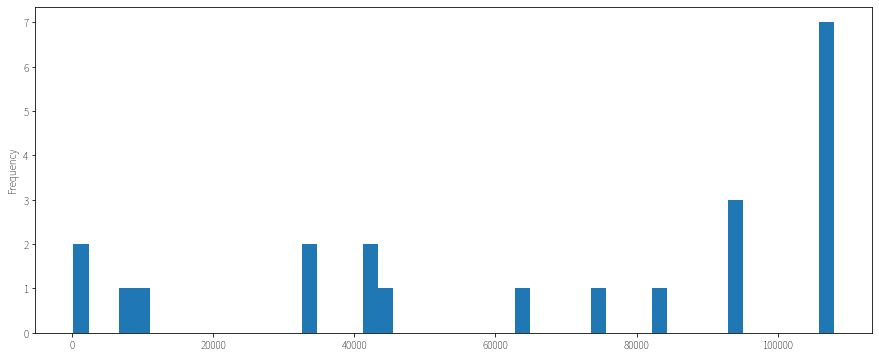

In [67]:
df[df["k_class"]==7]["floor_area"].plot.hist(bins=50)

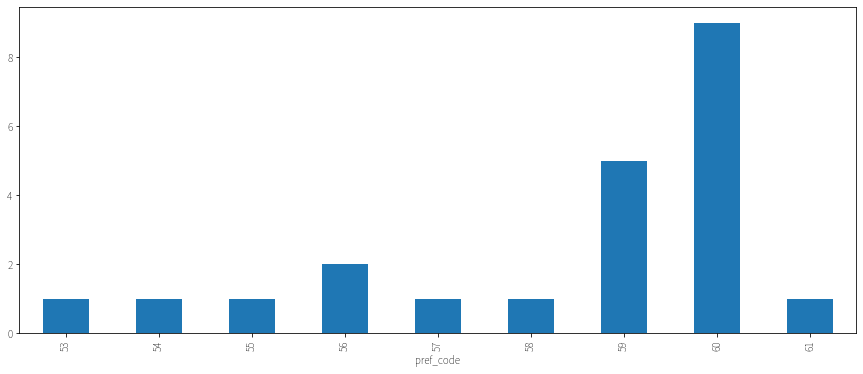

In [68]:
df[df["k_class"]==7].groupby("pref_code").size().plot.bar()

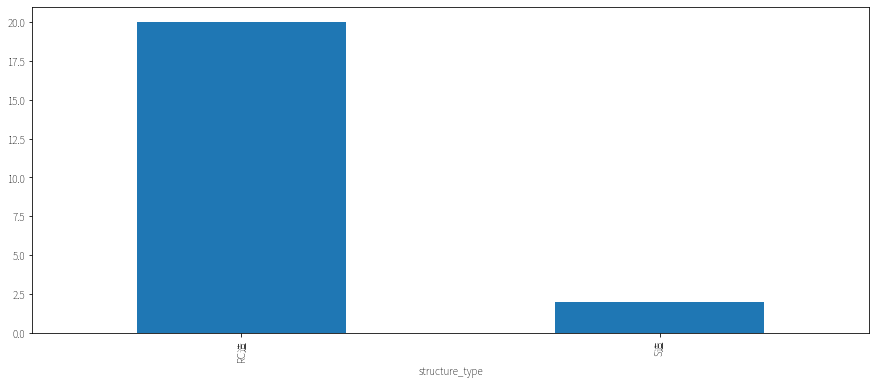

In [69]:
df[df["k_class"]==7].groupby("structure_type").size().plot.bar()

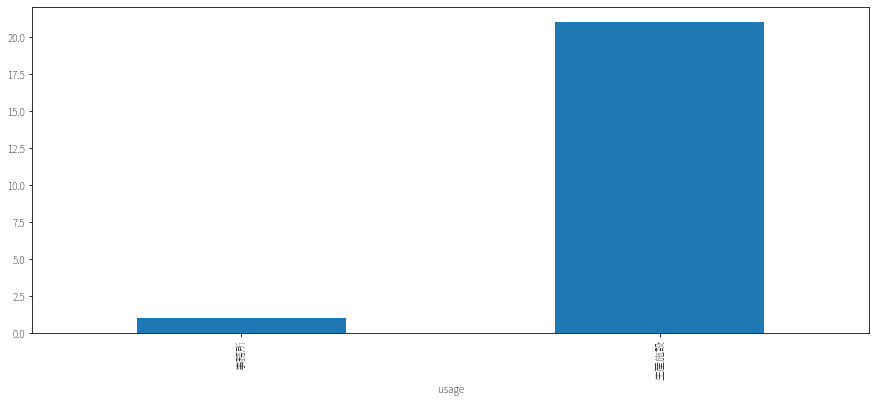

In [70]:
df[df["k_class"]==7].groupby("usage").size().plot.bar()

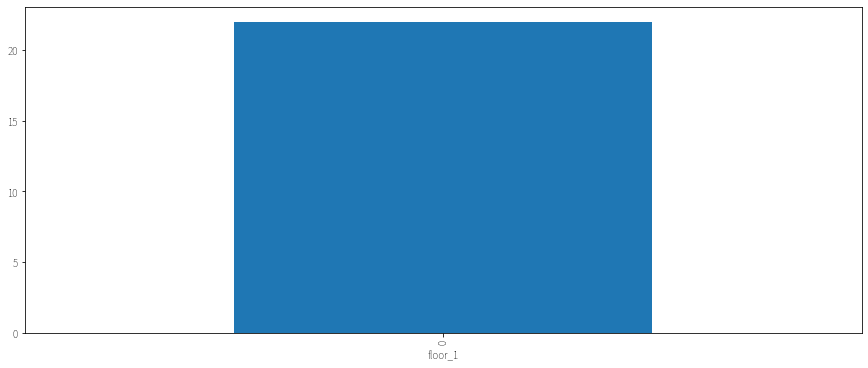

In [71]:
df[df["k_class"]==7].groupby("floor_1").size().plot.bar()

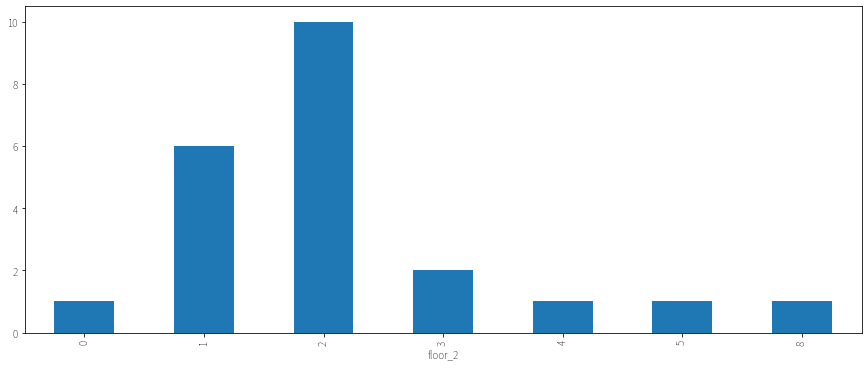

In [72]:
df[df["k_class"]==7].groupby("floor_2").size().plot.bar()

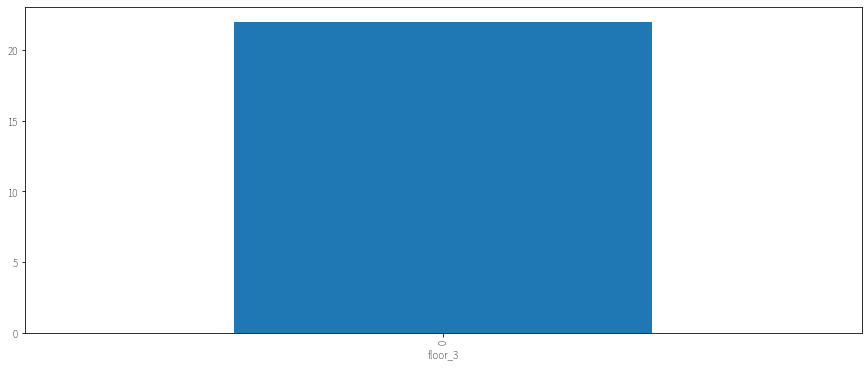

In [73]:
df[df["k_class"]==7].groupby("floor_3").size().plot.bar()

In [74]:
df[df["k_class"]==7]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
4,93 09A002,ホンダ・タイ工場環境試験室増設工事,生産施設,海外タイ アユタヤ県,500.00,0-0-0,RC造,55,764,0,0,0,7
72,93 10A018,三菱商事ニューデリー支店内装工事,事務所,海外インド ﾃﾞﾘｰ,250.00,0-5-0,S造,53,356,0,5,0,7
188,79 11B392A,キヤノンフィリピン工場新築工事,生産施設,海外フィリピン バタンガス州,83437.69,0-2-0,RC造,61,608,0,2,0,7
379,79 11B427A,東芝半導体工場タイ（ＴＳＴ）４期工事,生産施設,海外タイ バンコク近郊,43349.00,0-3-1,RC造,56,764,0,3,0,7
383,79 11B427B,東芝半導体工場タイ（ＴＳＴ）追加工事,生産施設,海外タイ バンコク近郊,43349.00,0-4-0,RC造,56,764,0,4,0,7
393,79 12A462A,※花王インドネシアＫＫＤプロジェクト,生産施設,海外インドネシア・西ジャワ カラワン,63735.00,0-8-0,S造,54,360,0,8,0,7
418,79 13A351A,※ホンダ４輪プラチンブリ新工場,生産施設,海外タイ・プラチンブリ県,94574.00,0-1-0,RC造,59,764,0,1,0,7
448,93 13A032A,ホンダ４輪プラチンブリエンジン新工場,生産施設,海外タイ プラチンブリ県,73570.00,0-1-0,RC造,58,764,0,1,0,7
482,79 13A716A,※ＥＰＰＩ新厚生棟新築・既存厚生棟改修工,生産施設,海外フィリピン,7483.00,0-3-0,RC造,60,608,0,3,0,7
496,79 14A513A,※エプソン・プレシジョンフィリピン３期,生産施設,海外フィリピン,108000.00,0-2-0,RC造,60,608,0,2,0,7


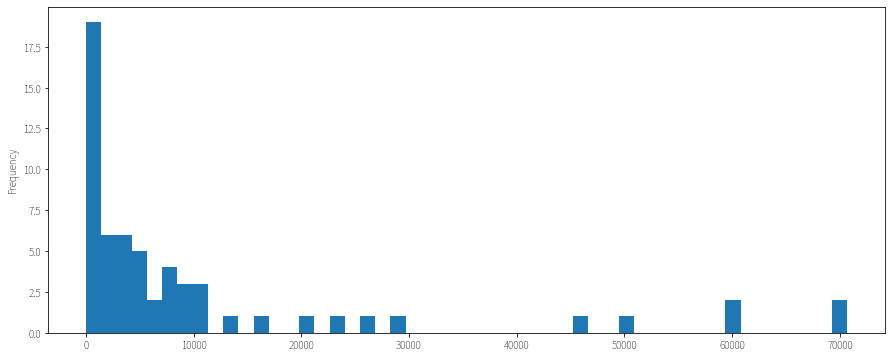

In [75]:
df[df["k_class"]==8]["floor_area"].plot.hist(bins=50)

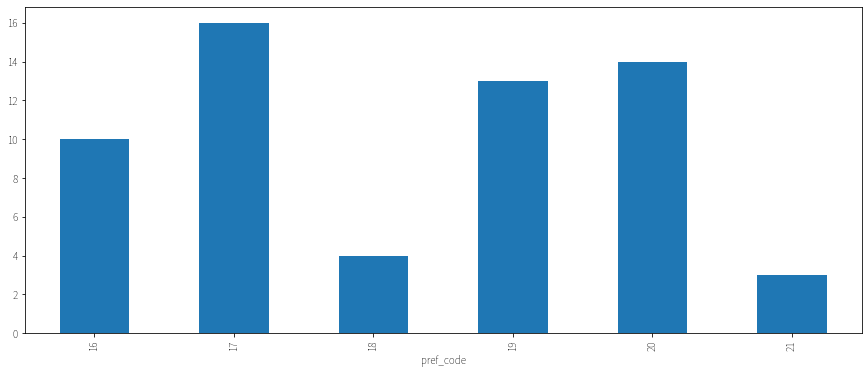

In [76]:
df[df["k_class"]==8].groupby("pref_code").size().plot.bar()

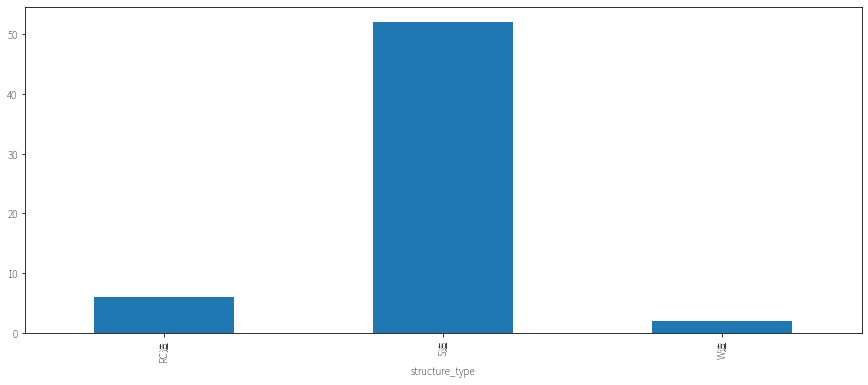

In [77]:
df[df["k_class"]==8].groupby("structure_type").size().plot.bar()

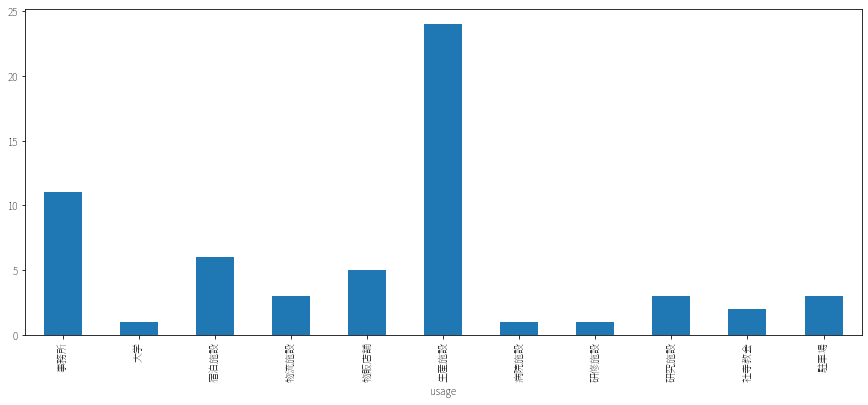

In [78]:
df[df["k_class"]==8].groupby("usage").size().plot.bar()

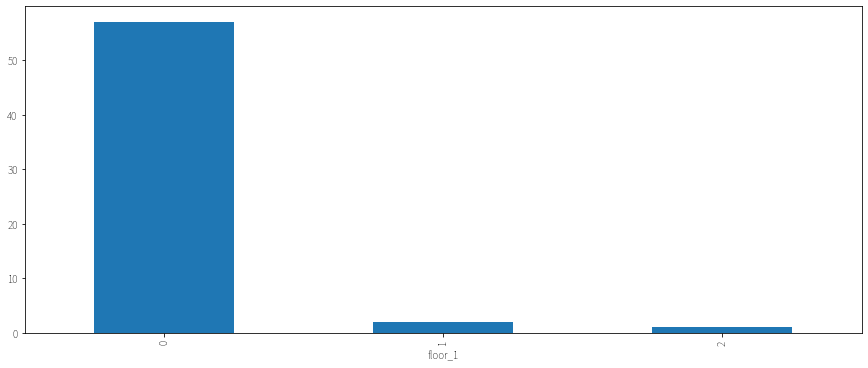

In [79]:
df[df["k_class"]==8].groupby("floor_1").size().plot.bar()

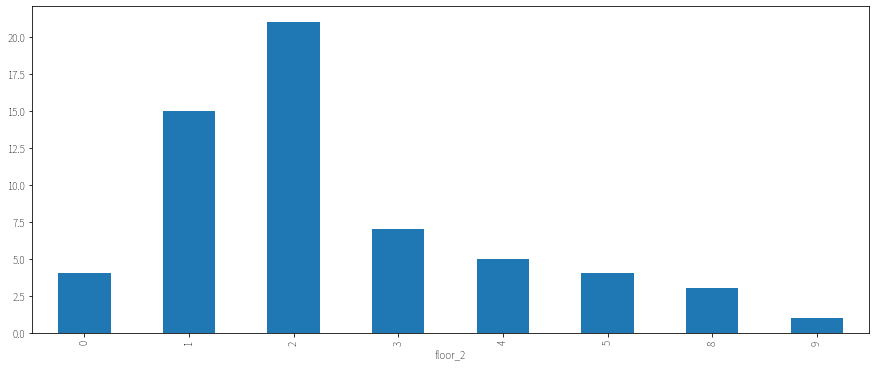

In [80]:
df[df["k_class"]==8].groupby("floor_2").size().plot.bar()

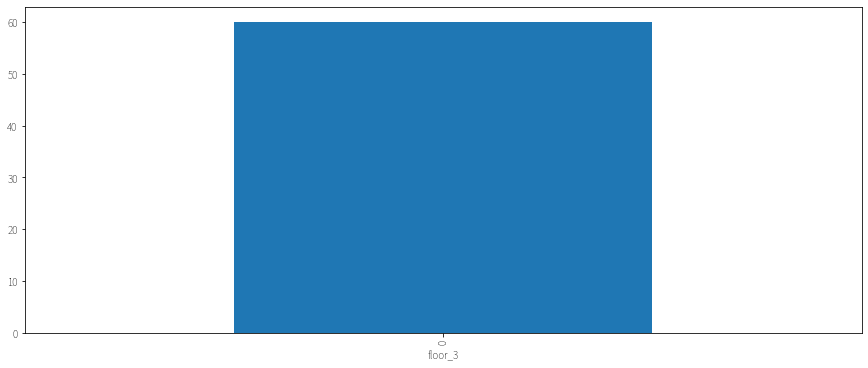

In [81]:
df[df["k_class"]==8].groupby("floor_3").size().plot.bar()

In [82]:
df[df["k_class"]==8]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
14,79 08A148B,イオンモール甲府昭和町ＳＣジャスコＢ工事,物販店舗,山梨県中巨摩郡昭和町,70657.00,0-3-0,S造,19,392,0,3,0,8
24,79 08A148E,イオンモール甲府昭和町ＳＣ（熱源受託工事,物販店舗,山梨県中巨摩郡昭和町,70657.00,0-3-0,RC造,19,392,0,3,0,8
32,75 09A013,立業社グループ社屋新築工事,事務所,富山県富山市,2037.00,0-4-1,S造,16,392,0,4,0,8
37,75 09A003,石川日産加賀店建替計画,事務所,石川県加賀市,786.00,0-1-0,S造,17,392,0,1,0,8
58,75 10A038,コマツ粟津工場パワートレイン試験棟建設工,生産施設,石川県小松市符津町ツ 23,6244.00,0-2-0,S造,17,392,0,2,0,8
74,75 09B036,北陸電気工事社屋移転新築工事,事務所,富山県富山市,6800.00,0-3-0,S造,16,392,0,3,0,8
80,79 10B078A,イビデン大垣中央事業場第２工場棟,生産施設,岐阜県大垣市,60600.00,0-5-0,S造,21,392,0,5,0,8
101,64 09B068A,岩谷瓦斯甲府工場ＬＧＣ充填施設土木建築,生産施設,山梨県中巨摩郡昭和町築地新居1824−1,110.00,0-1-0,S造,19,392,0,1,0,8
123,64 08B012C,コガネイ駒ヶ根事業所新社屋新築工事,生産施設,長野県駒ヶ根市飯坂 2-6-1,8083.00,0-2-0,S造,20,392,0,2,0,8
124,75 10A043,デンヨー福井工場事務棟新築工事,事務所,福井県三方上中郡若狭町相田38-1,2000.00,0-2-0,S造,18,392,0,2,0,8


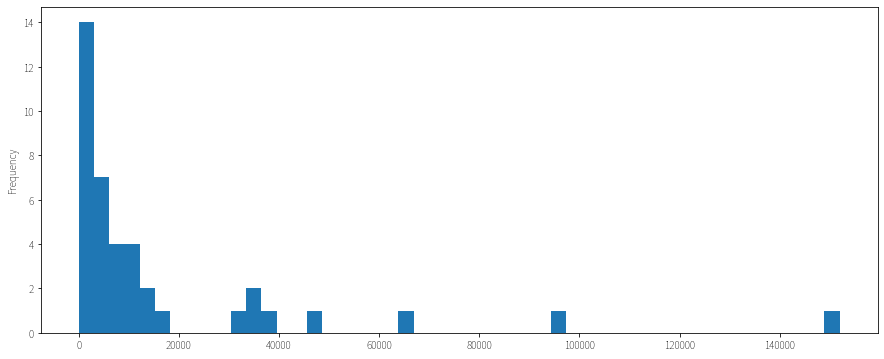

In [83]:
df[df["k_class"]==9]["floor_area"].plot.hist(bins=50)

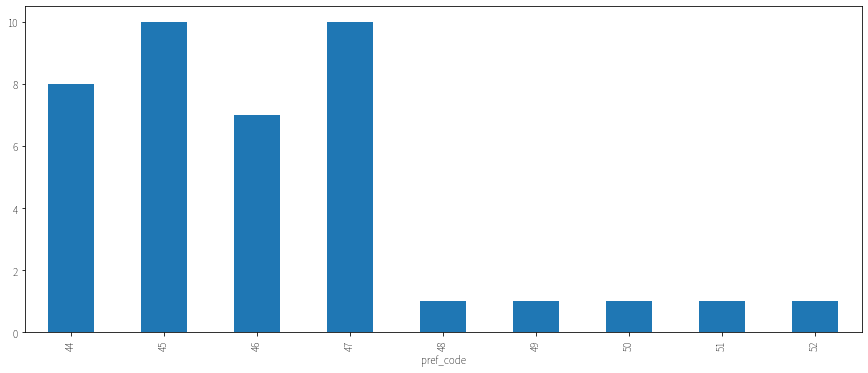

In [84]:
df[df["k_class"]==9].groupby("pref_code").size().plot.bar()

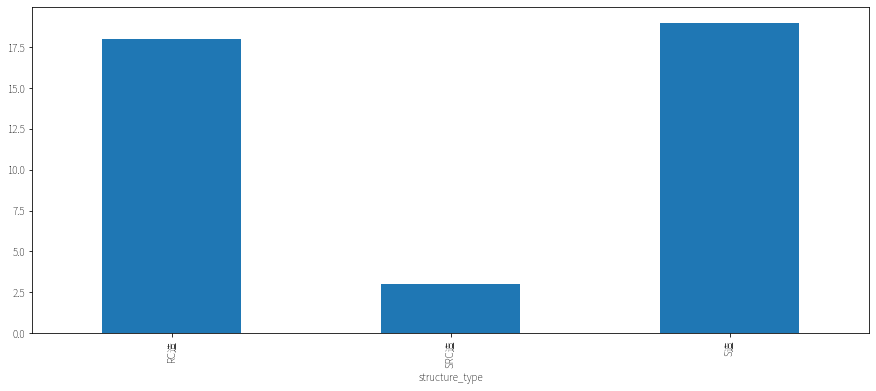

In [85]:
df[df["k_class"]==9].groupby("structure_type").size().plot.bar()

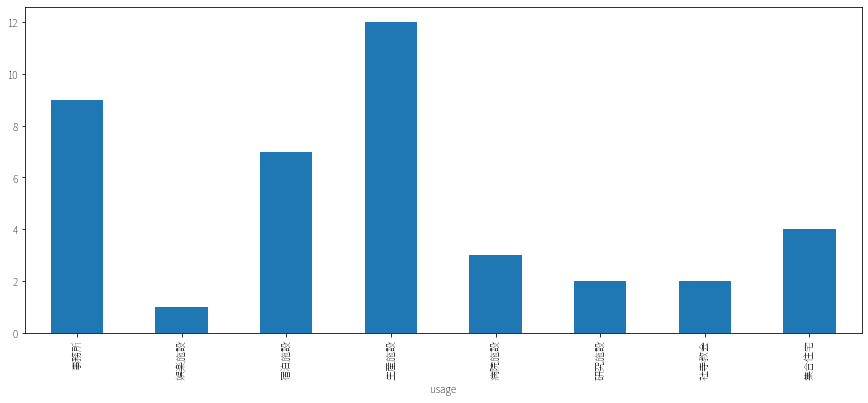

In [86]:
df[df["k_class"]==9].groupby("usage").size().plot.bar()

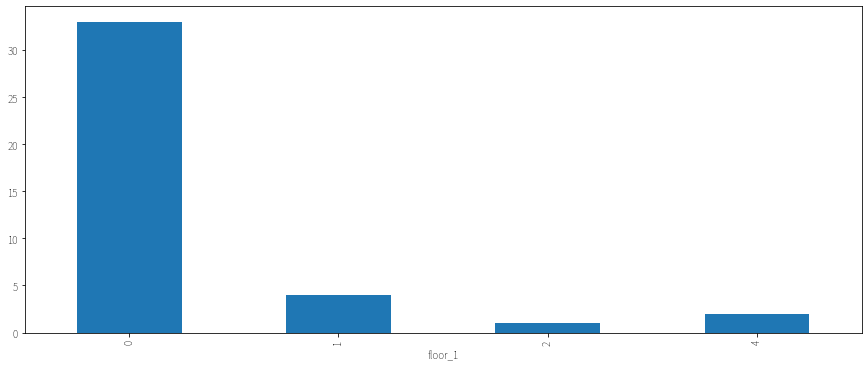

In [87]:
df[df["k_class"]==9].groupby("floor_1").size().plot.bar()

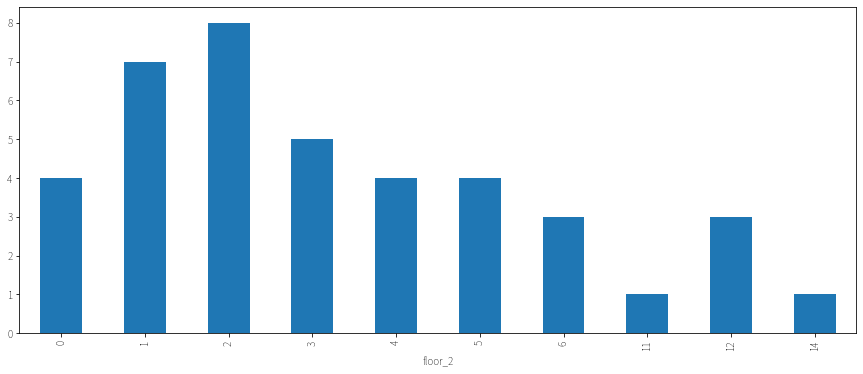

In [88]:
df[df["k_class"]==9].groupby("floor_2").size().plot.bar()

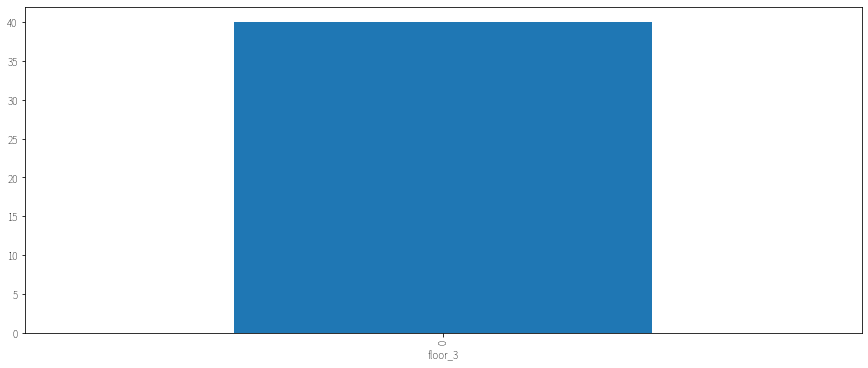

In [89]:
df[df["k_class"]==9].groupby("floor_3").size().plot.bar()

In [90]:
df[df["k_class"]==9]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
17,93 09A039,コベルコ建機インド新工場建設工事,研究施設,海外インド SRI-CITY,5992.00,0-2-0,SRC造,48,356,0,2,0,9
18,74 08B005A,宮崎県民共済自社ビル（設計変更対応）,事務所,宮崎県宮崎市宮脇町１２７−１,3000.00,0-5-0,RC造,45,392,0,5,0,9
46,74 09A034,大分サレジアンシスターズ修道院聖堂改築,社寺教会,大分県大分市,2104.75,0-3-0,RC造,44,392,0,3,0,9
52,74 10A022,ニチレイロジ九州曽於物流センター新築工事,生産施設,鹿児島県曽於市,8666.46,0-1-0,S造,46,392,0,1,0,9
55,74 10B024,豊通リサイクル沖縄出張所計画,事務所,沖縄糸満,408.00,0-1-0,S造,47,392,0,1,0,9
75,74 10A011,ウエルライフ３号館新築工事,集合住宅,宮崎県都城市,9954.40,0-4-0,RC造,45,392,0,4,0,9
149,93 10A006S,ブリヂストンインド第２工場新築工事,生産施設,海外インド マハラシュトプネ,96846.36,0-1-0,S造,51,356,0,1,0,9
225,74 11B011,大田ベーカリー建替計画,生産施設,鹿児島県鹿児島市,3234.90,0-1-0,S造,46,392,0,1,0,9
226,74 10B079,平安病院新館建築計画,病院施設,沖縄県浦添市,8518.14,0-6-0,RC造,47,392,0,6,0,9
237,79 11A860A,※ＨＭＳＩ第３工場建設工事,生産施設,海外インド カルナタカ州,151950.19,0-2-0,S造,50,356,0,2,0,9
